In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Práctica 7.3. Neural style transfer


Además de Deep Dream, otro importante desarrollo en modificación de imágenes es la trasferencia de estilo, desarrollado por Leon Gatys y otros durante el verano de 2015.

Existen muchas variantes del algoritmo de transferencia de estilo basados en el original que se han ido adaptando y mejorando. Algunos de ellos incluso se han adaptado para ser usado en aplicaciones móviles. Por simplicidad nos centraremos en el algoritmo descrito en el artículo original.

La transferencia de estilo consiste en aplicar el estilo, usualmente pictórico, de una imagen de referencia a otra imagen, normalmente una fotografía:

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

Lo que nosotros entenderemos por "estilo" es esencialmente las texturas, colores y los patrones visuales de la imagen en varias escalas espaciales. Por otro lado, entenderemos por "contenido" a la macroestructura de la imagen. Por ejemplo, en la imagen anterior los trazos circulares azules y amarillos son considerados estilos, mientras que los edificios de la fotografía son considerados "contenido".

La idea detrás de la transferencia de estilo está muy relacionada con la generación de texturas que ha sido muy estudiada en el procesamiento de imágenes. Sin embargo los resultados obtenidos con técnicas de deep learning mejoran enórmemente los obtenidos previamente con las técnicas clásicas de procesamiento de imágenes.

La noción clave detrás de esta técnica es la misma que la hemos visto en varias aplicaciones anteriormente: definir una función de coste que especifique que queremos alcanzar a través de la minimización. En este caso lo que queremos alcanzar es la conservación del "contenido" de la imagen original mientras se adopta el "estilo" de la imagen de referencia. Si somos capaces de definir matemáticamente qué es el contenido y qué es el estilo entonces podremos definir esta función de coste como:

$$
loss = distancia(estilo(imagen\_de\_ref) - estilo(imagen\_gen)) +
       distancia(contenido(imagen\_orig) - contenido(imagen\_gen))
$$


Donde la "distancia" será la norma L2, $contenido$ una función que dada una imagen extrae su "contenido" y $estilo$ es una función que dada una imagen extrae su "estilo"

Minimizando esta función de coste conseguiremos que $estilo(imagen\_gen)$ se aproxime a $estilo(imagen\_ref)$ y que $contenido(imagen\_gen)$ se aproxime a $contenido(imagen\_gen)$.

Una observación fundamental realizada por Gatus et al. fue que la redes convolucionales ofrecen precisamente un forma para definir matemáticamente el "estilo" y el "contenido".

## 1. El coste del contenido

Como ya sabemos, la activaciones de las primeras capas en una red detectan información muy *local* sobre la imagen, mientras que las activaciones más profundas representan la información más *global* y *abstracta*. Dicho de otra forma, las activaciones de la red proporcionan una descomposición del contenido de la imagen a diferentes escalas. Por tanto, se espera que el *contenido* de la imagen, el cual es más global y abstracto, sea capturado por la representaciones de las últimas capas.

Un buen candidato para una función pérdida del *contenido* sería entonces considerar un convnet pre-entrenada, y definir como nuestra pérdida la norma L2 entre las activaciones de una capa superior calculada sobre la imagen objetivo y las activaciones de la misma capa calculadas sobre la imagen generada. Esto garantizaría que, tal y como se ve desde la capa superior de la red convolucional, la imagen generada "se verá similar" a la imagen de destino original. Asumiendo que lo que ven las capas superiores de una red convolucional es realmente el "contenido" de sus imágenes de entrada, entonces esto funciona como una forma de preservar el contenido de la imagen.

## 2. El coste del estilo

Mientras que para el contenido solo se usa una capa superior, la parte de la función de coste destinada al estilo usa varias capas de la red según establece Gatys et al en el artículo original: se pretende extraer el estilo en todas las escalas no únicamente en una de ellas.

Para el cálculo de esta parte del coste, Gatys usa una matriz de Gram sobre las activaciones de las capas, por ejemplo el producto *interior* entre los mapas de características de una capa. Este producto *interior* se puede ver como una representación de las correlaciones entre la caracterísicas de una capa. Esas correlaciones capturan los patrones estadísticos de una escala en particular, lo cual corresponde empíricamente a la apariencia de las texturas encontradas en esa escala.

Por lo tanto, la pérdida de estilo tiene como objetivo preservar correlaciones internas similares dentro de las activaciones de las diferentes capas, a través de la imagen de referencia del estilo y de la imagen generada. A su vez, esto garantiza que las texturas encontradas a diferentes escalas espaciales se vean similares a través de la imagen de referencia de estilo y la imagen generada.

## 3. En resumen

Usaremos una red convolucional pre-entrenada  para definir una función de coste en la que:

* Preservaremos el contenido manteniendo *activaciones* de capa similares de alto nivel entre la imagen de contenido de destino y la imagen generada. La red debe "ver" tanto la imagen de destino como la imagen generada como "que contiene las mismas cosas".
* Preservaremos el estilo manteniendo *correlaciones* similares dentro de las activaciones tanto para las capas de bajo nivel como para las de alto nivel. De hecho, las correlaciones de las características capturan las texturas: la imagen de referencia generada y el estilo deben compartir las mismas texturas a diferentes escalas espaciales.

Veremos que la implementación del artículo original en Keras contiene partes muy similares a las usadas en el ejemplo de Deep Dream.

## 4. Neural style transfer en Keras

Podemos usar cualquier red pre-entrenada. En este ejemplo usaremos la VGG19, usada por Gatys. 

Haremos lo siguiente:

* Configuraremos la red para extraer las activaciones de las capas seleccionadas de la imagen generada y la de referencia.
* Usaremos las activaciones para calcular la función de coste definida, la cual vamos a minimizar.
* Usaremos el proceso del gradiente descendente para minimizar la función coste.

Vamos a empezar definiendo las rutas de la imágenes a usar asegurando que ambas tiene un tamaño similar. Más adelante las redimensionaremos a 400px de alto.


In [2]:
from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'img/giralda.jpg'
style_reference_image_path = 'img/ambroise-vollard.jpg'

# Dimensiones de la imagen
width, height = load_img(target_image_path).size

# Calculamos el ancho si redimensionamos a 400px de alto
img_height = 400
img_width = int(width * img_height / height)

Necesitaremos un par de funciones auxiliares para preprocesar y post-procesar las imagenes que daremos y que obtedremos de la VGG19:

In [3]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Eliminar el cero centro por píxel medio
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Le pasaremos a la red un bloque de 3 imágenes. La imagen de referencia de estilo, la de cotenido y un contenedor donde se generará la nueva imagen. Para definir este contenedor en Keras usaremos un *placeholder*, que es simplemente un tensor simbólico (como ya vimos en el módulo 3 con tensorflow). 

La imagen de referencia y la de contenido son estáticas por lo que las definimos con *K.constant*, mientras que los valores del placeholder deberán ir cambiando en cada paso de la optimización con el gradiente descendente.

In [4]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# Contenedor de la imagen a generar
combination_image = K.placeholder((1, img_height, img_width, 3))

# Combinamos las 3 imágenes un solo batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# Cargamos la VGG19 indicando que usaremos 3 imágenes como entrada
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Modelo cargado.')

W1021 20:06:18.756834 139714559878976 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1021 20:06:18.758969 139714559878976 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1021 20:06:18.759559 139714559878976 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1021 20:06:18.773759 139714559878976 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1021 20:06:19.0356

Modelo cargado.


Definimos la función de coste de contenido:

In [5]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

Definimos una función auxiliar para calcular la matriz de Gram de una matriz de entrada:

In [6]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

Ahora podemos definir la función de coste de estilo:

In [7]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

Además de las componentes de estilo y contenido vamos a añadir una componente adicional para evitar un exceso de pixelado. Para ello establecemos que debe existir continuidad entre cada pixel y su vecino de la derecha y con el de abajo.

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


La función de coste final será una media ponderada de los costes anteriores. 

Dependiendo del estilo de la imagen de referencia y de la imagen de contenido que estés utilizando, es probable que desees ajustar el coeficiente `content_weight`, la contribución de la pérdida de contenido a la pérdida total. Un `content_weight` más alto significa que el contenido de destino será más reconocible en la imagen generada.

In [9]:
# Diccionario con las capas de la red
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Capa de contenido
content_layer = 'block5_conv2'

# Capas de estilo
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Pesos de cada componente de la función de coste
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Definimos la funcon de coste final
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

# coste de "contenido"
loss += content_weight * content_loss(target_image_features, combination_features)

# coste de "estilo"
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

# coste de "continuidad"
loss += total_variation_weight * total_variation_loss(combination_image)

W1021 20:06:19.513682 139714559878976 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


Por último, configuramos el gradiente descendente. En el artículo original se usaba el algoritmo L-BFG. Dado que ya lo tenemos implementado en scipy lo usaremos también aunque tiene un par de inconvenientes:

* Es necesario pasarle el valor de la función de coste y el valor de gradientes en dos funciones por separado.
* Solo puede ser aplicada a vectores de 1D (nosotros tenemos un vector de imágenes 2D).

La clase `Evaluator` calculará ambos a la vez por eficiencia:

In [10]:
# Obtener los gradientes de la imagen generada con respecto la pérdida
grads = K.gradients(loss, combination_image)[0]

# Función para obtener los valores de la pérdida actual y de los gradientes actuales.
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

W1021 20:06:19.626935 139714559878976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Por fin, podemos ejecutar el proceso del gradiente descendente usando la función `fmin_l_bfgs_b` de scipy. Guardaremos la imagen generada cada 100 iteraciones.

In [11]:
from scipy.optimize import fmin_l_bfgs_b
from imageio import imsave
import os
import time

# si no existe la carpeta tmp (solo la primera vez):
#save_dir = './tmp'
#os.mkdir(save_dir)

result_prefix = 'tmp/style_transfer_result'
iterations = 10000

x = preprocess_image(target_image_path)
# aplanamos la imagen ya que fmin_l_bfgs_b solo 
# funciona con vectores de 1D
x = x.flatten()
for i in range(iterations):
    print('Comenzando la iteración', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Valor de pérdida actual:', min_val)
    # Guardamos la imagen actual generada
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    end_time = time.time()
    print('Imagen guardada como', fname)
    print('Iteración %d completada en %ds' % (i, end_time - start_time))
    
    if i % 100 == 0:
        imsave(fname, img)

imsave(fname, img)

Comenzando la iteración 0
Valor de pérdida actual: 362473300.0
Imagen guardada como tmp/style_transfer_result_at_iteration_0.png
Iteración 0 completada en 7s
Comenzando la iteración 1
Valor de pérdida actual: 193559840.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1.png
Iteración 1 completada en 4s
Comenzando la iteración 2
Valor de pérdida actual: 141185310.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2.png
Iteración 2 completada en 4s
Comenzando la iteración 3
Valor de pérdida actual: 114735280.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3.png
Iteración 3 completada en 4s
Comenzando la iteración 4
Valor de pérdida actual: 100899770.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4.png
Iteración 4 completada en 4s
Comenzando la iteración 5
Valor de pérdida actual: 90510250.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5.png
Iteración 5 completada en 4s
Comenzando la iteración 6
Valor de pérdida actual: 81

Valor de pérdida actual: 23752640.0
Imagen guardada como tmp/style_transfer_result_at_iteration_52.png
Iteración 52 completada en 4s
Comenzando la iteración 53
Valor de pérdida actual: 23608782.0
Imagen guardada como tmp/style_transfer_result_at_iteration_53.png
Iteración 53 completada en 4s
Comenzando la iteración 54
Valor de pérdida actual: 23475754.0
Imagen guardada como tmp/style_transfer_result_at_iteration_54.png
Iteración 54 completada en 4s
Comenzando la iteración 55
Valor de pérdida actual: 23342678.0
Imagen guardada como tmp/style_transfer_result_at_iteration_55.png
Iteración 55 completada en 4s
Comenzando la iteración 56
Valor de pérdida actual: 23221922.0
Imagen guardada como tmp/style_transfer_result_at_iteration_56.png
Iteración 56 completada en 4s
Comenzando la iteración 57
Valor de pérdida actual: 23049044.0
Imagen guardada como tmp/style_transfer_result_at_iteration_57.png
Iteración 57 completada en 4s
Comenzando la iteración 58
Valor de pérdida actual: 22907888.0
Imag

Valor de pérdida actual: 18841896.0
Imagen guardada como tmp/style_transfer_result_at_iteration_104.png
Iteración 104 completada en 4s
Comenzando la iteración 105
Valor de pérdida actual: 18786904.0
Imagen guardada como tmp/style_transfer_result_at_iteration_105.png
Iteración 105 completada en 4s
Comenzando la iteración 106
Valor de pérdida actual: 18726556.0
Imagen guardada como tmp/style_transfer_result_at_iteration_106.png
Iteración 106 completada en 4s
Comenzando la iteración 107
Valor de pérdida actual: 18661194.0
Imagen guardada como tmp/style_transfer_result_at_iteration_107.png
Iteración 107 completada en 4s
Comenzando la iteración 108
Valor de pérdida actual: 18614992.0
Imagen guardada como tmp/style_transfer_result_at_iteration_108.png
Iteración 108 completada en 4s
Comenzando la iteración 109
Valor de pérdida actual: 18560620.0
Imagen guardada como tmp/style_transfer_result_at_iteration_109.png
Iteración 109 completada en 4s
Comenzando la iteración 110
Valor de pérdida actua

Valor de pérdida actual: 16603747.0
Imagen guardada como tmp/style_transfer_result_at_iteration_155.png
Iteración 155 completada en 4s
Comenzando la iteración 156
Valor de pérdida actual: 16568543.0
Imagen guardada como tmp/style_transfer_result_at_iteration_156.png
Iteración 156 completada en 4s
Comenzando la iteración 157
Valor de pérdida actual: 16531881.0
Imagen guardada como tmp/style_transfer_result_at_iteration_157.png
Iteración 157 completada en 4s
Comenzando la iteración 158
Valor de pérdida actual: 16499547.0
Imagen guardada como tmp/style_transfer_result_at_iteration_158.png
Iteración 158 completada en 4s
Comenzando la iteración 159
Valor de pérdida actual: 16469750.0
Imagen guardada como tmp/style_transfer_result_at_iteration_159.png
Iteración 159 completada en 4s
Comenzando la iteración 160
Valor de pérdida actual: 16444538.0
Imagen guardada como tmp/style_transfer_result_at_iteration_160.png
Iteración 160 completada en 4s
Comenzando la iteración 161
Valor de pérdida actua

Valor de pérdida actual: 15385633.0
Imagen guardada como tmp/style_transfer_result_at_iteration_206.png
Iteración 206 completada en 4s
Comenzando la iteración 207
Valor de pérdida actual: 15350957.0
Imagen guardada como tmp/style_transfer_result_at_iteration_207.png
Iteración 207 completada en 4s
Comenzando la iteración 208
Valor de pérdida actual: 15328643.0
Imagen guardada como tmp/style_transfer_result_at_iteration_208.png
Iteración 208 completada en 4s
Comenzando la iteración 209
Valor de pérdida actual: 15305226.0
Imagen guardada como tmp/style_transfer_result_at_iteration_209.png
Iteración 209 completada en 4s
Comenzando la iteración 210
Valor de pérdida actual: 15290069.0
Imagen guardada como tmp/style_transfer_result_at_iteration_210.png
Iteración 210 completada en 4s
Comenzando la iteración 211
Valor de pérdida actual: 15275554.0
Imagen guardada como tmp/style_transfer_result_at_iteration_211.png
Iteración 211 completada en 4s
Comenzando la iteración 212
Valor de pérdida actua

Valor de pérdida actual: 14539562.0
Imagen guardada como tmp/style_transfer_result_at_iteration_257.png
Iteración 257 completada en 4s
Comenzando la iteración 258
Valor de pérdida actual: 14526148.0
Imagen guardada como tmp/style_transfer_result_at_iteration_258.png
Iteración 258 completada en 4s
Comenzando la iteración 259
Valor de pérdida actual: 14512387.0
Imagen guardada como tmp/style_transfer_result_at_iteration_259.png
Iteración 259 completada en 4s
Comenzando la iteración 260
Valor de pérdida actual: 14495725.0
Imagen guardada como tmp/style_transfer_result_at_iteration_260.png
Iteración 260 completada en 4s
Comenzando la iteración 261
Valor de pérdida actual: 14481023.0
Imagen guardada como tmp/style_transfer_result_at_iteration_261.png
Iteración 261 completada en 4s
Comenzando la iteración 262
Valor de pérdida actual: 14462560.0
Imagen guardada como tmp/style_transfer_result_at_iteration_262.png
Iteración 262 completada en 4s
Comenzando la iteración 263
Valor de pérdida actua

Valor de pérdida actual: 13930748.0
Imagen guardada como tmp/style_transfer_result_at_iteration_308.png
Iteración 308 completada en 4s
Comenzando la iteración 309
Valor de pérdida actual: 13922521.0
Imagen guardada como tmp/style_transfer_result_at_iteration_309.png
Iteración 309 completada en 4s
Comenzando la iteración 310
Valor de pérdida actual: 13913109.0
Imagen guardada como tmp/style_transfer_result_at_iteration_310.png
Iteración 310 completada en 4s
Comenzando la iteración 311
Valor de pérdida actual: 13901960.0
Imagen guardada como tmp/style_transfer_result_at_iteration_311.png
Iteración 311 completada en 4s
Comenzando la iteración 312
Valor de pérdida actual: 13890997.0
Imagen guardada como tmp/style_transfer_result_at_iteration_312.png
Iteración 312 completada en 4s
Comenzando la iteración 313
Valor de pérdida actual: 13877754.0
Imagen guardada como tmp/style_transfer_result_at_iteration_313.png
Iteración 313 completada en 4s
Comenzando la iteración 314
Valor de pérdida actua

Valor de pérdida actual: 13442809.0
Imagen guardada como tmp/style_transfer_result_at_iteration_359.png
Iteración 359 completada en 4s
Comenzando la iteración 360
Valor de pérdida actual: 13434790.0
Imagen guardada como tmp/style_transfer_result_at_iteration_360.png
Iteración 360 completada en 4s
Comenzando la iteración 361
Valor de pérdida actual: 13423849.0
Imagen guardada como tmp/style_transfer_result_at_iteration_361.png
Iteración 361 completada en 4s
Comenzando la iteración 362
Valor de pérdida actual: 13413038.0
Imagen guardada como tmp/style_transfer_result_at_iteration_362.png
Iteración 362 completada en 4s
Comenzando la iteración 363
Valor de pérdida actual: 13400406.0
Imagen guardada como tmp/style_transfer_result_at_iteration_363.png
Iteración 363 completada en 4s
Comenzando la iteración 364
Valor de pérdida actual: 13392703.0
Imagen guardada como tmp/style_transfer_result_at_iteration_364.png
Iteración 364 completada en 4s
Comenzando la iteración 365
Valor de pérdida actua

Valor de pérdida actual: 13034564.0
Imagen guardada como tmp/style_transfer_result_at_iteration_410.png
Iteración 410 completada en 4s
Comenzando la iteración 411
Valor de pérdida actual: 13029057.0
Imagen guardada como tmp/style_transfer_result_at_iteration_411.png
Iteración 411 completada en 4s
Comenzando la iteración 412
Valor de pérdida actual: 13022253.0
Imagen guardada como tmp/style_transfer_result_at_iteration_412.png
Iteración 412 completada en 4s
Comenzando la iteración 413
Valor de pérdida actual: 13016086.0
Imagen guardada como tmp/style_transfer_result_at_iteration_413.png
Iteración 413 completada en 4s
Comenzando la iteración 414
Valor de pérdida actual: 13008133.0
Imagen guardada como tmp/style_transfer_result_at_iteration_414.png
Iteración 414 completada en 4s
Comenzando la iteración 415
Valor de pérdida actual: 13002795.0
Imagen guardada como tmp/style_transfer_result_at_iteration_415.png
Iteración 415 completada en 4s
Comenzando la iteración 416
Valor de pérdida actua

Valor de pérdida actual: 12724599.0
Imagen guardada como tmp/style_transfer_result_at_iteration_461.png
Iteración 461 completada en 4s
Comenzando la iteración 462
Valor de pérdida actual: 12717589.0
Imagen guardada como tmp/style_transfer_result_at_iteration_462.png
Iteración 462 completada en 4s
Comenzando la iteración 463
Valor de pérdida actual: 12711744.0
Imagen guardada como tmp/style_transfer_result_at_iteration_463.png
Iteración 463 completada en 4s
Comenzando la iteración 464
Valor de pérdida actual: 12704258.0
Imagen guardada como tmp/style_transfer_result_at_iteration_464.png
Iteración 464 completada en 4s
Comenzando la iteración 465
Valor de pérdida actual: 12698618.0
Imagen guardada como tmp/style_transfer_result_at_iteration_465.png
Iteración 465 completada en 4s
Comenzando la iteración 466
Valor de pérdida actual: 12689214.0
Imagen guardada como tmp/style_transfer_result_at_iteration_466.png
Iteración 466 completada en 4s
Comenzando la iteración 467
Valor de pérdida actua

Valor de pérdida actual: 12444471.0
Imagen guardada como tmp/style_transfer_result_at_iteration_512.png
Iteración 512 completada en 4s
Comenzando la iteración 513
Valor de pérdida actual: 12439725.0
Imagen guardada como tmp/style_transfer_result_at_iteration_513.png
Iteración 513 completada en 4s
Comenzando la iteración 514
Valor de pérdida actual: 12436289.0
Imagen guardada como tmp/style_transfer_result_at_iteration_514.png
Iteración 514 completada en 4s
Comenzando la iteración 515
Valor de pérdida actual: 12432272.0
Imagen guardada como tmp/style_transfer_result_at_iteration_515.png
Iteración 515 completada en 4s
Comenzando la iteración 516
Valor de pérdida actual: 12426753.0
Imagen guardada como tmp/style_transfer_result_at_iteration_516.png
Iteración 516 completada en 4s
Comenzando la iteración 517
Valor de pérdida actual: 12422260.0
Imagen guardada como tmp/style_transfer_result_at_iteration_517.png
Iteración 517 completada en 4s
Comenzando la iteración 518
Valor de pérdida actua

Valor de pérdida actual: 12232420.0
Imagen guardada como tmp/style_transfer_result_at_iteration_563.png
Iteración 563 completada en 4s
Comenzando la iteración 564
Valor de pérdida actual: 12229205.0
Imagen guardada como tmp/style_transfer_result_at_iteration_564.png
Iteración 564 completada en 4s
Comenzando la iteración 565
Valor de pérdida actual: 12225743.0
Imagen guardada como tmp/style_transfer_result_at_iteration_565.png
Iteración 565 completada en 4s
Comenzando la iteración 566
Valor de pérdida actual: 12222551.0
Imagen guardada como tmp/style_transfer_result_at_iteration_566.png
Iteración 566 completada en 4s
Comenzando la iteración 567
Valor de pérdida actual: 12219397.0
Imagen guardada como tmp/style_transfer_result_at_iteration_567.png
Iteración 567 completada en 4s
Comenzando la iteración 568
Valor de pérdida actual: 12215998.0
Imagen guardada como tmp/style_transfer_result_at_iteration_568.png
Iteración 568 completada en 4s
Comenzando la iteración 569
Valor de pérdida actua

Valor de pérdida actual: 12048997.0
Imagen guardada como tmp/style_transfer_result_at_iteration_614.png
Iteración 614 completada en 4s
Comenzando la iteración 615
Valor de pérdida actual: 12046097.0
Imagen guardada como tmp/style_transfer_result_at_iteration_615.png
Iteración 615 completada en 4s
Comenzando la iteración 616
Valor de pérdida actual: 12042657.0
Imagen guardada como tmp/style_transfer_result_at_iteration_616.png
Iteración 616 completada en 4s
Comenzando la iteración 617
Valor de pérdida actual: 12040043.0
Imagen guardada como tmp/style_transfer_result_at_iteration_617.png
Iteración 617 completada en 4s
Comenzando la iteración 618
Valor de pérdida actual: 12037028.0
Imagen guardada como tmp/style_transfer_result_at_iteration_618.png
Iteración 618 completada en 4s
Comenzando la iteración 619
Valor de pérdida actual: 12034465.0
Imagen guardada como tmp/style_transfer_result_at_iteration_619.png
Iteración 619 completada en 4s
Comenzando la iteración 620
Valor de pérdida actua

Valor de pérdida actual: 11897120.0
Imagen guardada como tmp/style_transfer_result_at_iteration_665.png
Iteración 665 completada en 4s
Comenzando la iteración 666
Valor de pérdida actual: 11894290.0
Imagen guardada como tmp/style_transfer_result_at_iteration_666.png
Iteración 666 completada en 4s
Comenzando la iteración 667
Valor de pérdida actual: 11892230.0
Imagen guardada como tmp/style_transfer_result_at_iteration_667.png
Iteración 667 completada en 4s
Comenzando la iteración 668
Valor de pérdida actual: 11889887.0
Imagen guardada como tmp/style_transfer_result_at_iteration_668.png
Iteración 668 completada en 4s
Comenzando la iteración 669
Valor de pérdida actual: 11887512.0
Imagen guardada como tmp/style_transfer_result_at_iteration_669.png
Iteración 669 completada en 4s
Comenzando la iteración 670
Valor de pérdida actual: 11885147.0
Imagen guardada como tmp/style_transfer_result_at_iteration_670.png
Iteración 670 completada en 4s
Comenzando la iteración 671
Valor de pérdida actua

Valor de pérdida actual: 11768169.0
Imagen guardada como tmp/style_transfer_result_at_iteration_716.png
Iteración 716 completada en 4s
Comenzando la iteración 717
Valor de pérdida actual: 11765133.0
Imagen guardada como tmp/style_transfer_result_at_iteration_717.png
Iteración 717 completada en 4s
Comenzando la iteración 718
Valor de pérdida actual: 11762672.0
Imagen guardada como tmp/style_transfer_result_at_iteration_718.png
Iteración 718 completada en 4s
Comenzando la iteración 719
Valor de pérdida actual: 11759610.0
Imagen guardada como tmp/style_transfer_result_at_iteration_719.png
Iteración 719 completada en 4s
Comenzando la iteración 720
Valor de pérdida actual: 11757209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_720.png
Iteración 720 completada en 4s
Comenzando la iteración 721
Valor de pérdida actual: 11754023.0
Imagen guardada como tmp/style_transfer_result_at_iteration_721.png
Iteración 721 completada en 4s
Comenzando la iteración 722
Valor de pérdida actua

Valor de pérdida actual: 11644436.0
Imagen guardada como tmp/style_transfer_result_at_iteration_767.png
Iteración 767 completada en 4s
Comenzando la iteración 768
Valor de pérdida actual: 11642350.0
Imagen guardada como tmp/style_transfer_result_at_iteration_768.png
Iteración 768 completada en 4s
Comenzando la iteración 769
Valor de pérdida actual: 11640609.0
Imagen guardada como tmp/style_transfer_result_at_iteration_769.png
Iteración 769 completada en 4s
Comenzando la iteración 770
Valor de pérdida actual: 11638415.0
Imagen guardada como tmp/style_transfer_result_at_iteration_770.png
Iteración 770 completada en 4s
Comenzando la iteración 771
Valor de pérdida actual: 11636718.0
Imagen guardada como tmp/style_transfer_result_at_iteration_771.png
Iteración 771 completada en 4s
Comenzando la iteración 772
Valor de pérdida actual: 11634666.0
Imagen guardada como tmp/style_transfer_result_at_iteration_772.png
Iteración 772 completada en 4s
Comenzando la iteración 773
Valor de pérdida actua

Valor de pérdida actual: 11555538.0
Imagen guardada como tmp/style_transfer_result_at_iteration_818.png
Iteración 818 completada en 4s
Comenzando la iteración 819
Valor de pérdida actual: 11553623.0
Imagen guardada como tmp/style_transfer_result_at_iteration_819.png
Iteración 819 completada en 4s
Comenzando la iteración 820
Valor de pérdida actual: 11552066.0
Imagen guardada como tmp/style_transfer_result_at_iteration_820.png
Iteración 820 completada en 4s
Comenzando la iteración 821
Valor de pérdida actual: 11550298.0
Imagen guardada como tmp/style_transfer_result_at_iteration_821.png
Iteración 821 completada en 4s
Comenzando la iteración 822
Valor de pérdida actual: 11548722.0
Imagen guardada como tmp/style_transfer_result_at_iteration_822.png
Iteración 822 completada en 4s
Comenzando la iteración 823
Valor de pérdida actual: 11546941.0
Imagen guardada como tmp/style_transfer_result_at_iteration_823.png
Iteración 823 completada en 4s
Comenzando la iteración 824
Valor de pérdida actua

Valor de pérdida actual: 11474786.0
Imagen guardada como tmp/style_transfer_result_at_iteration_869.png
Iteración 869 completada en 4s
Comenzando la iteración 870
Valor de pérdida actual: 11473438.0
Imagen guardada como tmp/style_transfer_result_at_iteration_870.png
Iteración 870 completada en 4s
Comenzando la iteración 871
Valor de pérdida actual: 11471948.0
Imagen guardada como tmp/style_transfer_result_at_iteration_871.png
Iteración 871 completada en 4s
Comenzando la iteración 872
Valor de pérdida actual: 11470675.0
Imagen guardada como tmp/style_transfer_result_at_iteration_872.png
Iteración 872 completada en 4s
Comenzando la iteración 873
Valor de pérdida actual: 11469237.0
Imagen guardada como tmp/style_transfer_result_at_iteration_873.png
Iteración 873 completada en 4s
Comenzando la iteración 874
Valor de pérdida actual: 11467914.0
Imagen guardada como tmp/style_transfer_result_at_iteration_874.png
Iteración 874 completada en 4s
Comenzando la iteración 875
Valor de pérdida actua

Valor de pérdida actual: 11406152.0
Imagen guardada como tmp/style_transfer_result_at_iteration_920.png
Iteración 920 completada en 4s
Comenzando la iteración 921
Valor de pérdida actual: 11404790.0
Imagen guardada como tmp/style_transfer_result_at_iteration_921.png
Iteración 921 completada en 4s
Comenzando la iteración 922
Valor de pérdida actual: 11403318.0
Imagen guardada como tmp/style_transfer_result_at_iteration_922.png
Iteración 922 completada en 4s
Comenzando la iteración 923
Valor de pérdida actual: 11402155.0
Imagen guardada como tmp/style_transfer_result_at_iteration_923.png
Iteración 923 completada en 4s
Comenzando la iteración 924
Valor de pérdida actual: 11400832.0
Imagen guardada como tmp/style_transfer_result_at_iteration_924.png
Iteración 924 completada en 4s
Comenzando la iteración 925
Valor de pérdida actual: 11399477.0
Imagen guardada como tmp/style_transfer_result_at_iteration_925.png
Iteración 925 completada en 4s
Comenzando la iteración 926
Valor de pérdida actua

Valor de pérdida actual: 11342777.0
Imagen guardada como tmp/style_transfer_result_at_iteration_971.png
Iteración 971 completada en 4s
Comenzando la iteración 972
Valor de pérdida actual: 11341763.0
Imagen guardada como tmp/style_transfer_result_at_iteration_972.png
Iteración 972 completada en 4s
Comenzando la iteración 973
Valor de pérdida actual: 11340663.0
Imagen guardada como tmp/style_transfer_result_at_iteration_973.png
Iteración 973 completada en 4s
Comenzando la iteración 974
Valor de pérdida actual: 11339622.0
Imagen guardada como tmp/style_transfer_result_at_iteration_974.png
Iteración 974 completada en 4s
Comenzando la iteración 975
Valor de pérdida actual: 11338561.0
Imagen guardada como tmp/style_transfer_result_at_iteration_975.png
Iteración 975 completada en 4s
Comenzando la iteración 976
Valor de pérdida actual: 11337522.0
Imagen guardada como tmp/style_transfer_result_at_iteration_976.png
Iteración 976 completada en 4s
Comenzando la iteración 977
Valor de pérdida actua

Valor de pérdida actual: 11286966.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1021.png
Iteración 1021 completada en 4s
Comenzando la iteración 1022
Valor de pérdida actual: 11286013.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1022.png
Iteración 1022 completada en 4s
Comenzando la iteración 1023
Valor de pérdida actual: 11284977.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1023.png
Iteración 1023 completada en 4s
Comenzando la iteración 1024
Valor de pérdida actual: 11283995.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1024.png
Iteración 1024 completada en 4s
Comenzando la iteración 1025
Valor de pérdida actual: 11282781.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1025.png
Iteración 1025 completada en 4s
Comenzando la iteración 1026
Valor de pérdida actual: 11281777.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1026.png
Iteración 1026 completada en 4s
Comenzando la iteración 1027
Valo

Valor de pérdida actual: 11235959.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1071.png
Iteración 1071 completada en 4s
Comenzando la iteración 1072
Valor de pérdida actual: 11235044.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1072.png
Iteración 1072 completada en 4s
Comenzando la iteración 1073
Valor de pérdida actual: 11234052.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1073.png
Iteración 1073 completada en 4s
Comenzando la iteración 1074
Valor de pérdida actual: 11233135.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1074.png
Iteración 1074 completada en 4s
Comenzando la iteración 1075
Valor de pérdida actual: 11232150.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1075.png
Iteración 1075 completada en 4s
Comenzando la iteración 1076
Valor de pérdida actual: 11231262.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1076.png
Iteración 1076 completada en 4s
Comenzando la iteración 1077
Valo

Valor de pérdida actual: 11190843.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1121.png
Iteración 1121 completada en 4s
Comenzando la iteración 1122
Valor de pérdida actual: 11189874.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1122.png
Iteración 1122 completada en 4s
Comenzando la iteración 1123
Valor de pérdida actual: 11188895.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1123.png
Iteración 1123 completada en 4s
Comenzando la iteración 1124
Valor de pérdida actual: 11188049.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1124.png
Iteración 1124 completada en 4s
Comenzando la iteración 1125
Valor de pérdida actual: 11187114.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1125.png
Iteración 1125 completada en 4s
Comenzando la iteración 1126
Valor de pérdida actual: 11186191.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1126.png
Iteración 1126 completada en 4s
Comenzando la iteración 1127
Valo

Valor de pérdida actual: 11149851.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1171.png
Iteración 1171 completada en 4s
Comenzando la iteración 1172
Valor de pérdida actual: 11149108.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1172.png
Iteración 1172 completada en 4s
Comenzando la iteración 1173
Valor de pérdida actual: 11148340.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1173.png
Iteración 1173 completada en 4s
Comenzando la iteración 1174
Valor de pérdida actual: 11147517.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1174.png
Iteración 1174 completada en 4s
Comenzando la iteración 1175
Valor de pérdida actual: 11146717.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1175.png
Iteración 1175 completada en 4s
Comenzando la iteración 1176
Valor de pérdida actual: 11145912.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1176.png
Iteración 1176 completada en 4s
Comenzando la iteración 1177
Valo

Valor de pérdida actual: 11116706.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1221.png
Iteración 1221 completada en 4s
Comenzando la iteración 1222
Valor de pérdida actual: 11116206.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1222.png
Iteración 1222 completada en 4s
Comenzando la iteración 1223
Valor de pérdida actual: 11115718.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1223.png
Iteración 1223 completada en 4s
Comenzando la iteración 1224
Valor de pérdida actual: 11115202.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1224.png
Iteración 1224 completada en 4s
Comenzando la iteración 1225
Valor de pérdida actual: 11114727.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1225.png
Iteración 1225 completada en 4s
Comenzando la iteración 1226
Valor de pérdida actual: 11114231.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1226.png
Iteración 1226 completada en 4s
Comenzando la iteración 1227
Valo

Valor de pérdida actual: 11092746.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1271.png
Iteración 1271 completada en 4s
Comenzando la iteración 1272
Valor de pérdida actual: 11092295.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1272.png
Iteración 1272 completada en 4s
Comenzando la iteración 1273
Valor de pérdida actual: 11091863.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1273.png
Iteración 1273 completada en 4s
Comenzando la iteración 1274
Valor de pérdida actual: 11091414.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1274.png
Iteración 1274 completada en 4s
Comenzando la iteración 1275
Valor de pérdida actual: 11090964.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1275.png
Iteración 1275 completada en 4s
Comenzando la iteración 1276
Valor de pérdida actual: 11090504.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1276.png
Iteración 1276 completada en 4s
Comenzando la iteración 1277
Valo

Valor de pérdida actual: 11073498.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1321.png
Iteración 1321 completada en 4s
Comenzando la iteración 1322
Valor de pérdida actual: 11073216.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1322.png
Iteración 1322 completada en 4s
Comenzando la iteración 1323
Valor de pérdida actual: 11072939.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1323.png
Iteración 1323 completada en 4s
Comenzando la iteración 1324
Valor de pérdida actual: 11072666.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1324.png
Iteración 1324 completada en 4s
Comenzando la iteración 1325
Valor de pérdida actual: 11072396.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1325.png
Iteración 1325 completada en 4s
Comenzando la iteración 1326
Valor de pérdida actual: 11072130.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1326.png
Iteración 1326 completada en 4s
Comenzando la iteración 1327
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1371.png
Iteración 1371 completada en 3s
Comenzando la iteración 1372
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1372.png
Iteración 1372 completada en 3s
Comenzando la iteración 1373
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1373.png
Iteración 1373 completada en 3s
Comenzando la iteración 1374
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1374.png
Iteración 1374 completada en 3s
Comenzando la iteración 1375
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1375.png
Iteración 1375 completada en 3s
Comenzando la iteración 1376
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1376.png
Iteración 1376 completada en 2s
Comenzando la iteración 1377
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1421.png
Iteración 1421 completada en 3s
Comenzando la iteración 1422
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1422.png
Iteración 1422 completada en 3s
Comenzando la iteración 1423
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1423.png
Iteración 1423 completada en 3s
Comenzando la iteración 1424
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1424.png
Iteración 1424 completada en 3s
Comenzando la iteración 1425
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1425.png
Iteración 1425 completada en 3s
Comenzando la iteración 1426
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1426.png
Iteración 1426 completada en 3s
Comenzando la iteración 1427
Valo

Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1471.png
Iteración 1471 completada en 3s
Comenzando la iteración 1472
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1472.png
Iteración 1472 completada en 3s
Comenzando la iteración 1473
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1473.png
Iteración 1473 completada en 3s
Comenzando la iteración 1474
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1474.png
Iteración 1474 completada en 3s
Comenzando la iteración 1475
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1475.png
Iteración 1475 completada en 3s
Comenzando la iteración 1476
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1476.png
Iteración 1476 completada en 3s
Comenzando la iteración 1477
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1521.png
Iteración 1521 completada en 3s
Comenzando la iteración 1522
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1522.png
Iteración 1522 completada en 3s
Comenzando la iteración 1523
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1523.png
Iteración 1523 completada en 3s
Comenzando la iteración 1524
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1524.png
Iteración 1524 completada en 3s
Comenzando la iteración 1525
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1525.png
Iteración 1525 completada en 3s
Comenzando la iteración 1526
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1526.png
Iteración 1526 completada en 3s
Comenzando la iteración 1527
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1571.png
Iteración 1571 completada en 3s
Comenzando la iteración 1572
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1572.png
Iteración 1572 completada en 3s
Comenzando la iteración 1573
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1573.png
Iteración 1573 completada en 3s
Comenzando la iteración 1574
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1574.png
Iteración 1574 completada en 3s
Comenzando la iteración 1575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1575.png
Iteración 1575 completada en 3s
Comenzando la iteración 1576
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1576.png
Iteración 1576 completada en 3s
Comenzando la iteración 1577
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1621.png
Iteración 1621 completada en 3s
Comenzando la iteración 1622
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1622.png
Iteración 1622 completada en 3s
Comenzando la iteración 1623
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1623.png
Iteración 1623 completada en 3s
Comenzando la iteración 1624
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1624.png
Iteración 1624 completada en 3s
Comenzando la iteración 1625
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1625.png
Iteración 1625 completada en 3s
Comenzando la iteración 1626
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1626.png
Iteración 1626 completada en 3s
Comenzando la iteración 1627
Valo

Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1671.png
Iteración 1671 completada en 3s
Comenzando la iteración 1672
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1672.png
Iteración 1672 completada en 3s
Comenzando la iteración 1673
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1673.png
Iteración 1673 completada en 3s
Comenzando la iteración 1674
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1674.png
Iteración 1674 completada en 3s
Comenzando la iteración 1675
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1675.png
Iteración 1675 completada en 3s
Comenzando la iteración 1676
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1676.png
Iteración 1676 completada en 3s
Comenzando la iteración 1677
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1721.png
Iteración 1721 completada en 3s
Comenzando la iteración 1722
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1722.png
Iteración 1722 completada en 3s
Comenzando la iteración 1723
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1723.png
Iteración 1723 completada en 3s
Comenzando la iteración 1724
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1724.png
Iteración 1724 completada en 3s
Comenzando la iteración 1725
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1725.png
Iteración 1725 completada en 3s
Comenzando la iteración 1726
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1726.png
Iteración 1726 completada en 3s
Comenzando la iteración 1727
Valo

Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1771.png
Iteración 1771 completada en 3s
Comenzando la iteración 1772
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1772.png
Iteración 1772 completada en 3s
Comenzando la iteración 1773
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1773.png
Iteración 1773 completada en 3s
Comenzando la iteración 1774
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1774.png
Iteración 1774 completada en 3s
Comenzando la iteración 1775
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1775.png
Iteración 1775 completada en 3s
Comenzando la iteración 1776
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1776.png
Iteración 1776 completada en 3s
Comenzando la iteración 1777
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1821.png
Iteración 1821 completada en 3s
Comenzando la iteración 1822
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1822.png
Iteración 1822 completada en 3s
Comenzando la iteración 1823
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1823.png
Iteración 1823 completada en 3s
Comenzando la iteración 1824
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1824.png
Iteración 1824 completada en 3s
Comenzando la iteración 1825
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1825.png
Iteración 1825 completada en 3s
Comenzando la iteración 1826
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1826.png
Iteración 1826 completada en 3s
Comenzando la iteración 1827
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1871.png
Iteración 1871 completada en 3s
Comenzando la iteración 1872
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1872.png
Iteración 1872 completada en 3s
Comenzando la iteración 1873
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1873.png
Iteración 1873 completada en 3s
Comenzando la iteración 1874
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1874.png
Iteración 1874 completada en 3s
Comenzando la iteración 1875
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1875.png
Iteración 1875 completada en 3s
Comenzando la iteración 1876
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1876.png
Iteración 1876 completada en 3s
Comenzando la iteración 1877
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1921.png
Iteración 1921 completada en 3s
Comenzando la iteración 1922
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1922.png
Iteración 1922 completada en 3s
Comenzando la iteración 1923
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1923.png
Iteración 1923 completada en 3s
Comenzando la iteración 1924
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1924.png
Iteración 1924 completada en 3s
Comenzando la iteración 1925
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1925.png
Iteración 1925 completada en 3s
Comenzando la iteración 1926
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1926.png
Iteración 1926 completada en 3s
Comenzando la iteración 1927
Valo

Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1971.png
Iteración 1971 completada en 3s
Comenzando la iteración 1972
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1972.png
Iteración 1972 completada en 3s
Comenzando la iteración 1973
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1973.png
Iteración 1973 completada en 3s
Comenzando la iteración 1974
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1974.png
Iteración 1974 completada en 3s
Comenzando la iteración 1975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1975.png
Iteración 1975 completada en 3s
Comenzando la iteración 1976
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_1976.png
Iteración 1976 completada en 3s
Comenzando la iteración 1977
Valo

Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2021.png
Iteración 2021 completada en 3s
Comenzando la iteración 2022
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2022.png
Iteración 2022 completada en 3s
Comenzando la iteración 2023
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2023.png
Iteración 2023 completada en 3s
Comenzando la iteración 2024
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2024.png
Iteración 2024 completada en 3s
Comenzando la iteración 2025
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2025.png
Iteración 2025 completada en 3s
Comenzando la iteración 2026
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2026.png
Iteración 2026 completada en 3s
Comenzando la iteración 2027
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2071.png
Iteración 2071 completada en 3s
Comenzando la iteración 2072
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2072.png
Iteración 2072 completada en 3s
Comenzando la iteración 2073
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2073.png
Iteración 2073 completada en 3s
Comenzando la iteración 2074
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2074.png
Iteración 2074 completada en 3s
Comenzando la iteración 2075
Valor de pérdida actual: 11068210.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2075.png
Iteración 2075 completada en 3s
Comenzando la iteración 2076
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2076.png
Iteración 2076 completada en 3s
Comenzando la iteración 2077
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2121.png
Iteración 2121 completada en 3s
Comenzando la iteración 2122
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2122.png
Iteración 2122 completada en 3s
Comenzando la iteración 2123
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2123.png
Iteración 2123 completada en 3s
Comenzando la iteración 2124
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2124.png
Iteración 2124 completada en 3s
Comenzando la iteración 2125
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2125.png
Iteración 2125 completada en 3s
Comenzando la iteración 2126
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2126.png
Iteración 2126 completada en 3s
Comenzando la iteración 2127
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2171.png
Iteración 2171 completada en 3s
Comenzando la iteración 2172
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2172.png
Iteración 2172 completada en 3s
Comenzando la iteración 2173
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2173.png
Iteración 2173 completada en 3s
Comenzando la iteración 2174
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2174.png
Iteración 2174 completada en 3s
Comenzando la iteración 2175
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2175.png
Iteración 2175 completada en 3s
Comenzando la iteración 2176
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2176.png
Iteración 2176 completada en 3s
Comenzando la iteración 2177
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2221.png
Iteración 2221 completada en 3s
Comenzando la iteración 2222
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2222.png
Iteración 2222 completada en 3s
Comenzando la iteración 2223
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2223.png
Iteración 2223 completada en 3s
Comenzando la iteración 2224
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2224.png
Iteración 2224 completada en 3s
Comenzando la iteración 2225
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2225.png
Iteración 2225 completada en 3s
Comenzando la iteración 2226
Valor de pérdida actual: 11068208.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2226.png
Iteración 2226 completada en 3s
Comenzando la iteración 2227
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2271.png
Iteración 2271 completada en 3s
Comenzando la iteración 2272
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2272.png
Iteración 2272 completada en 3s
Comenzando la iteración 2273
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2273.png
Iteración 2273 completada en 3s
Comenzando la iteración 2274
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2274.png
Iteración 2274 completada en 3s
Comenzando la iteración 2275
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2275.png
Iteración 2275 completada en 3s
Comenzando la iteración 2276
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2276.png
Iteración 2276 completada en 3s
Comenzando la iteración 2277
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2321.png
Iteración 2321 completada en 3s
Comenzando la iteración 2322
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2322.png
Iteración 2322 completada en 3s
Comenzando la iteración 2323
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2323.png
Iteración 2323 completada en 3s
Comenzando la iteración 2324
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2324.png
Iteración 2324 completada en 3s
Comenzando la iteración 2325
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2325.png
Iteración 2325 completada en 3s
Comenzando la iteración 2326
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2326.png
Iteración 2326 completada en 3s
Comenzando la iteración 2327
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2371.png
Iteración 2371 completada en 3s
Comenzando la iteración 2372
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2372.png
Iteración 2372 completada en 3s
Comenzando la iteración 2373
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2373.png
Iteración 2373 completada en 3s
Comenzando la iteración 2374
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2374.png
Iteración 2374 completada en 3s
Comenzando la iteración 2375
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2375.png
Iteración 2375 completada en 3s
Comenzando la iteración 2376
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2376.png
Iteración 2376 completada en 3s
Comenzando la iteración 2377
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2421.png
Iteración 2421 completada en 3s
Comenzando la iteración 2422
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2422.png
Iteración 2422 completada en 3s
Comenzando la iteración 2423
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2423.png
Iteración 2423 completada en 3s
Comenzando la iteración 2424
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2424.png
Iteración 2424 completada en 3s
Comenzando la iteración 2425
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2425.png
Iteración 2425 completada en 3s
Comenzando la iteración 2426
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2426.png
Iteración 2426 completada en 3s
Comenzando la iteración 2427
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2471.png
Iteración 2471 completada en 3s
Comenzando la iteración 2472
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2472.png
Iteración 2472 completada en 3s
Comenzando la iteración 2473
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2473.png
Iteración 2473 completada en 3s
Comenzando la iteración 2474
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2474.png
Iteración 2474 completada en 3s
Comenzando la iteración 2475
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2475.png
Iteración 2475 completada en 3s
Comenzando la iteración 2476
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2476.png
Iteración 2476 completada en 3s
Comenzando la iteración 2477
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2521.png
Iteración 2521 completada en 3s
Comenzando la iteración 2522
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2522.png
Iteración 2522 completada en 3s
Comenzando la iteración 2523
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2523.png
Iteración 2523 completada en 3s
Comenzando la iteración 2524
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2524.png
Iteración 2524 completada en 3s
Comenzando la iteración 2525
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2525.png
Iteración 2525 completada en 3s
Comenzando la iteración 2526
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2526.png
Iteración 2526 completada en 3s
Comenzando la iteración 2527
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2571.png
Iteración 2571 completada en 3s
Comenzando la iteración 2572
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2572.png
Iteración 2572 completada en 3s
Comenzando la iteración 2573
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2573.png
Iteración 2573 completada en 3s
Comenzando la iteración 2574
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2574.png
Iteración 2574 completada en 3s
Comenzando la iteración 2575
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2575.png
Iteración 2575 completada en 3s
Comenzando la iteración 2576
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2576.png
Iteración 2576 completada en 3s
Comenzando la iteración 2577
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2621.png
Iteración 2621 completada en 3s
Comenzando la iteración 2622
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2622.png
Iteración 2622 completada en 3s
Comenzando la iteración 2623
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2623.png
Iteración 2623 completada en 3s
Comenzando la iteración 2624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2624.png
Iteración 2624 completada en 3s
Comenzando la iteración 2625
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2625.png
Iteración 2625 completada en 3s
Comenzando la iteración 2626
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2626.png
Iteración 2626 completada en 3s
Comenzando la iteración 2627
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2671.png
Iteración 2671 completada en 3s
Comenzando la iteración 2672
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2672.png
Iteración 2672 completada en 3s
Comenzando la iteración 2673
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2673.png
Iteración 2673 completada en 3s
Comenzando la iteración 2674
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2674.png
Iteración 2674 completada en 3s
Comenzando la iteración 2675
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2675.png
Iteración 2675 completada en 3s
Comenzando la iteración 2676
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2676.png
Iteración 2676 completada en 3s
Comenzando la iteración 2677
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2721.png
Iteración 2721 completada en 3s
Comenzando la iteración 2722
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2722.png
Iteración 2722 completada en 3s
Comenzando la iteración 2723
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2723.png
Iteración 2723 completada en 3s
Comenzando la iteración 2724
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2724.png
Iteración 2724 completada en 3s
Comenzando la iteración 2725
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2725.png
Iteración 2725 completada en 3s
Comenzando la iteración 2726
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2726.png
Iteración 2726 completada en 3s
Comenzando la iteración 2727
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2771.png
Iteración 2771 completada en 3s
Comenzando la iteración 2772
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2772.png
Iteración 2772 completada en 3s
Comenzando la iteración 2773
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2773.png
Iteración 2773 completada en 3s
Comenzando la iteración 2774
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2774.png
Iteración 2774 completada en 3s
Comenzando la iteración 2775
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2775.png
Iteración 2775 completada en 3s
Comenzando la iteración 2776
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2776.png
Iteración 2776 completada en 3s
Comenzando la iteración 2777
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2821.png
Iteración 2821 completada en 3s
Comenzando la iteración 2822
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2822.png
Iteración 2822 completada en 3s
Comenzando la iteración 2823
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2823.png
Iteración 2823 completada en 3s
Comenzando la iteración 2824
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2824.png
Iteración 2824 completada en 3s
Comenzando la iteración 2825
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2825.png
Iteración 2825 completada en 3s
Comenzando la iteración 2826
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2826.png
Iteración 2826 completada en 3s
Comenzando la iteración 2827
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2871.png
Iteración 2871 completada en 3s
Comenzando la iteración 2872
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2872.png
Iteración 2872 completada en 3s
Comenzando la iteración 2873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2873.png
Iteración 2873 completada en 3s
Comenzando la iteración 2874
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2874.png
Iteración 2874 completada en 3s
Comenzando la iteración 2875
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2875.png
Iteración 2875 completada en 3s
Comenzando la iteración 2876
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2876.png
Iteración 2876 completada en 3s
Comenzando la iteración 2877
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2921.png
Iteración 2921 completada en 3s
Comenzando la iteración 2922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2922.png
Iteración 2922 completada en 3s
Comenzando la iteración 2923
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2923.png
Iteración 2923 completada en 3s
Comenzando la iteración 2924
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2924.png
Iteración 2924 completada en 3s
Comenzando la iteración 2925
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2925.png
Iteración 2925 completada en 3s
Comenzando la iteración 2926
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2926.png
Iteración 2926 completada en 3s
Comenzando la iteración 2927
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2971.png
Iteración 2971 completada en 3s
Comenzando la iteración 2972
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2972.png
Iteración 2972 completada en 3s
Comenzando la iteración 2973
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2973.png
Iteración 2973 completada en 3s
Comenzando la iteración 2974
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2974.png
Iteración 2974 completada en 3s
Comenzando la iteración 2975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2975.png
Iteración 2975 completada en 3s
Comenzando la iteración 2976
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_2976.png
Iteración 2976 completada en 3s
Comenzando la iteración 2977
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3021.png
Iteración 3021 completada en 3s
Comenzando la iteración 3022
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3022.png
Iteración 3022 completada en 3s
Comenzando la iteración 3023
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3023.png
Iteración 3023 completada en 3s
Comenzando la iteración 3024
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3024.png
Iteración 3024 completada en 3s
Comenzando la iteración 3025
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3025.png
Iteración 3025 completada en 3s
Comenzando la iteración 3026
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3026.png
Iteración 3026 completada en 3s
Comenzando la iteración 3027
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3071.png
Iteración 3071 completada en 3s
Comenzando la iteración 3072
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3072.png
Iteración 3072 completada en 3s
Comenzando la iteración 3073
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3073.png
Iteración 3073 completada en 3s
Comenzando la iteración 3074
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3074.png
Iteración 3074 completada en 3s
Comenzando la iteración 3075
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3075.png
Iteración 3075 completada en 3s
Comenzando la iteración 3076
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3076.png
Iteración 3076 completada en 3s
Comenzando la iteración 3077
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3121.png
Iteración 3121 completada en 3s
Comenzando la iteración 3122
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3122.png
Iteración 3122 completada en 3s
Comenzando la iteración 3123
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3123.png
Iteración 3123 completada en 3s
Comenzando la iteración 3124
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3124.png
Iteración 3124 completada en 3s
Comenzando la iteración 3125
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3125.png
Iteración 3125 completada en 3s
Comenzando la iteración 3126
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3126.png
Iteración 3126 completada en 3s
Comenzando la iteración 3127
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3171.png
Iteración 3171 completada en 3s
Comenzando la iteración 3172
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3172.png
Iteración 3172 completada en 3s
Comenzando la iteración 3173
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3173.png
Iteración 3173 completada en 3s
Comenzando la iteración 3174
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3174.png
Iteración 3174 completada en 3s
Comenzando la iteración 3175
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3175.png
Iteración 3175 completada en 3s
Comenzando la iteración 3176
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3176.png
Iteración 3176 completada en 3s
Comenzando la iteración 3177
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3221.png
Iteración 3221 completada en 3s
Comenzando la iteración 3222
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3222.png
Iteración 3222 completada en 3s
Comenzando la iteración 3223
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3223.png
Iteración 3223 completada en 3s
Comenzando la iteración 3224
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3224.png
Iteración 3224 completada en 3s
Comenzando la iteración 3225
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3225.png
Iteración 3225 completada en 3s
Comenzando la iteración 3226
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3226.png
Iteración 3226 completada en 3s
Comenzando la iteración 3227
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3271.png
Iteración 3271 completada en 3s
Comenzando la iteración 3272
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3272.png
Iteración 3272 completada en 3s
Comenzando la iteración 3273
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3273.png
Iteración 3273 completada en 3s
Comenzando la iteración 3274
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3274.png
Iteración 3274 completada en 3s
Comenzando la iteración 3275
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3275.png
Iteración 3275 completada en 3s
Comenzando la iteración 3276
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3276.png
Iteración 3276 completada en 3s
Comenzando la iteración 3277
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3321.png
Iteración 3321 completada en 3s
Comenzando la iteración 3322
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3322.png
Iteración 3322 completada en 3s
Comenzando la iteración 3323
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3323.png
Iteración 3323 completada en 3s
Comenzando la iteración 3324
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3324.png
Iteración 3324 completada en 3s
Comenzando la iteración 3325
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3325.png
Iteración 3325 completada en 3s
Comenzando la iteración 3326
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3326.png
Iteración 3326 completada en 3s
Comenzando la iteración 3327
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3371.png
Iteración 3371 completada en 3s
Comenzando la iteración 3372
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3372.png
Iteración 3372 completada en 3s
Comenzando la iteración 3373
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3373.png
Iteración 3373 completada en 3s
Comenzando la iteración 3374
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3374.png
Iteración 3374 completada en 3s
Comenzando la iteración 3375
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3375.png
Iteración 3375 completada en 3s
Comenzando la iteración 3376
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3376.png
Iteración 3376 completada en 3s
Comenzando la iteración 3377
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3421.png
Iteración 3421 completada en 3s
Comenzando la iteración 3422
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3422.png
Iteración 3422 completada en 3s
Comenzando la iteración 3423
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3423.png
Iteración 3423 completada en 3s
Comenzando la iteración 3424
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3424.png
Iteración 3424 completada en 3s
Comenzando la iteración 3425
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3425.png
Iteración 3425 completada en 3s
Comenzando la iteración 3426
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3426.png
Iteración 3426 completada en 3s
Comenzando la iteración 3427
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3471.png
Iteración 3471 completada en 3s
Comenzando la iteración 3472
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3472.png
Iteración 3472 completada en 3s
Comenzando la iteración 3473
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3473.png
Iteración 3473 completada en 3s
Comenzando la iteración 3474
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3474.png
Iteración 3474 completada en 3s
Comenzando la iteración 3475
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3475.png
Iteración 3475 completada en 3s
Comenzando la iteración 3476
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3476.png
Iteración 3476 completada en 3s
Comenzando la iteración 3477
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3521.png
Iteración 3521 completada en 3s
Comenzando la iteración 3522
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3522.png
Iteración 3522 completada en 3s
Comenzando la iteración 3523
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3523.png
Iteración 3523 completada en 3s
Comenzando la iteración 3524
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3524.png
Iteración 3524 completada en 3s
Comenzando la iteración 3525
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3525.png
Iteración 3525 completada en 3s
Comenzando la iteración 3526
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3526.png
Iteración 3526 completada en 3s
Comenzando la iteración 3527
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3571.png
Iteración 3571 completada en 3s
Comenzando la iteración 3572
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3572.png
Iteración 3572 completada en 3s
Comenzando la iteración 3573
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3573.png
Iteración 3573 completada en 3s
Comenzando la iteración 3574
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3574.png
Iteración 3574 completada en 3s
Comenzando la iteración 3575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3575.png
Iteración 3575 completada en 3s
Comenzando la iteración 3576
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3576.png
Iteración 3576 completada en 3s
Comenzando la iteración 3577
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3621.png
Iteración 3621 completada en 3s
Comenzando la iteración 3622
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3622.png
Iteración 3622 completada en 3s
Comenzando la iteración 3623
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3623.png
Iteración 3623 completada en 3s
Comenzando la iteración 3624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3624.png
Iteración 3624 completada en 3s
Comenzando la iteración 3625
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3625.png
Iteración 3625 completada en 3s
Comenzando la iteración 3626
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3626.png
Iteración 3626 completada en 3s
Comenzando la iteración 3627
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3671.png
Iteración 3671 completada en 3s
Comenzando la iteración 3672
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3672.png
Iteración 3672 completada en 3s
Comenzando la iteración 3673
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3673.png
Iteración 3673 completada en 3s
Comenzando la iteración 3674
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3674.png
Iteración 3674 completada en 3s
Comenzando la iteración 3675
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3675.png
Iteración 3675 completada en 3s
Comenzando la iteración 3676
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3676.png
Iteración 3676 completada en 3s
Comenzando la iteración 3677
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3721.png
Iteración 3721 completada en 3s
Comenzando la iteración 3722
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3722.png
Iteración 3722 completada en 3s
Comenzando la iteración 3723
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3723.png
Iteración 3723 completada en 3s
Comenzando la iteración 3724
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3724.png
Iteración 3724 completada en 3s
Comenzando la iteración 3725
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3725.png
Iteración 3725 completada en 3s
Comenzando la iteración 3726
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3726.png
Iteración 3726 completada en 3s
Comenzando la iteración 3727
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3771.png
Iteración 3771 completada en 3s
Comenzando la iteración 3772
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3772.png
Iteración 3772 completada en 3s
Comenzando la iteración 3773
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3773.png
Iteración 3773 completada en 3s
Comenzando la iteración 3774
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3774.png
Iteración 3774 completada en 3s
Comenzando la iteración 3775
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3775.png
Iteración 3775 completada en 3s
Comenzando la iteración 3776
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3776.png
Iteración 3776 completada en 3s
Comenzando la iteración 3777
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3821.png
Iteración 3821 completada en 3s
Comenzando la iteración 3822
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3822.png
Iteración 3822 completada en 3s
Comenzando la iteración 3823
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3823.png
Iteración 3823 completada en 3s
Comenzando la iteración 3824
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3824.png
Iteración 3824 completada en 3s
Comenzando la iteración 3825
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3825.png
Iteración 3825 completada en 3s
Comenzando la iteración 3826
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3826.png
Iteración 3826 completada en 3s
Comenzando la iteración 3827
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3871.png
Iteración 3871 completada en 3s
Comenzando la iteración 3872
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3872.png
Iteración 3872 completada en 3s
Comenzando la iteración 3873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3873.png
Iteración 3873 completada en 3s
Comenzando la iteración 3874
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3874.png
Iteración 3874 completada en 3s
Comenzando la iteración 3875
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3875.png
Iteración 3875 completada en 3s
Comenzando la iteración 3876
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3876.png
Iteración 3876 completada en 3s
Comenzando la iteración 3877
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3921.png
Iteración 3921 completada en 3s
Comenzando la iteración 3922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3922.png
Iteración 3922 completada en 3s
Comenzando la iteración 3923
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3923.png
Iteración 3923 completada en 3s
Comenzando la iteración 3924
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3924.png
Iteración 3924 completada en 3s
Comenzando la iteración 3925
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3925.png
Iteración 3925 completada en 3s
Comenzando la iteración 3926
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3926.png
Iteración 3926 completada en 3s
Comenzando la iteración 3927
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3971.png
Iteración 3971 completada en 3s
Comenzando la iteración 3972
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3972.png
Iteración 3972 completada en 3s
Comenzando la iteración 3973
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3973.png
Iteración 3973 completada en 3s
Comenzando la iteración 3974
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3974.png
Iteración 3974 completada en 3s
Comenzando la iteración 3975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3975.png
Iteración 3975 completada en 3s
Comenzando la iteración 3976
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_3976.png
Iteración 3976 completada en 3s
Comenzando la iteración 3977
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4021.png
Iteración 4021 completada en 3s
Comenzando la iteración 4022
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4022.png
Iteración 4022 completada en 3s
Comenzando la iteración 4023
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4023.png
Iteración 4023 completada en 3s
Comenzando la iteración 4024
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4024.png
Iteración 4024 completada en 3s
Comenzando la iteración 4025
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4025.png
Iteración 4025 completada en 3s
Comenzando la iteración 4026
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4026.png
Iteración 4026 completada en 3s
Comenzando la iteración 4027
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4071.png
Iteración 4071 completada en 3s
Comenzando la iteración 4072
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4072.png
Iteración 4072 completada en 3s
Comenzando la iteración 4073
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4073.png
Iteración 4073 completada en 3s
Comenzando la iteración 4074
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4074.png
Iteración 4074 completada en 3s
Comenzando la iteración 4075
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4075.png
Iteración 4075 completada en 3s
Comenzando la iteración 4076
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4076.png
Iteración 4076 completada en 3s
Comenzando la iteración 4077
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4121.png
Iteración 4121 completada en 3s
Comenzando la iteración 4122
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4122.png
Iteración 4122 completada en 3s
Comenzando la iteración 4123
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4123.png
Iteración 4123 completada en 3s
Comenzando la iteración 4124
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4124.png
Iteración 4124 completada en 3s
Comenzando la iteración 4125
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4125.png
Iteración 4125 completada en 3s
Comenzando la iteración 4126
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4126.png
Iteración 4126 completada en 3s
Comenzando la iteración 4127
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4171.png
Iteración 4171 completada en 3s
Comenzando la iteración 4172
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4172.png
Iteración 4172 completada en 3s
Comenzando la iteración 4173
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4173.png
Iteración 4173 completada en 3s
Comenzando la iteración 4174
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4174.png
Iteración 4174 completada en 3s
Comenzando la iteración 4175
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4175.png
Iteración 4175 completada en 3s
Comenzando la iteración 4176
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4176.png
Iteración 4176 completada en 3s
Comenzando la iteración 4177
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4221.png
Iteración 4221 completada en 3s
Comenzando la iteración 4222
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4222.png
Iteración 4222 completada en 3s
Comenzando la iteración 4223
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4223.png
Iteración 4223 completada en 3s
Comenzando la iteración 4224
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4224.png
Iteración 4224 completada en 3s
Comenzando la iteración 4225
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4225.png
Iteración 4225 completada en 3s
Comenzando la iteración 4226
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4226.png
Iteración 4226 completada en 3s
Comenzando la iteración 4227
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4271.png
Iteración 4271 completada en 3s
Comenzando la iteración 4272
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4272.png
Iteración 4272 completada en 3s
Comenzando la iteración 4273
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4273.png
Iteración 4273 completada en 3s
Comenzando la iteración 4274
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4274.png
Iteración 4274 completada en 3s
Comenzando la iteración 4275
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4275.png
Iteración 4275 completada en 3s
Comenzando la iteración 4276
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4276.png
Iteración 4276 completada en 3s
Comenzando la iteración 4277
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4321.png
Iteración 4321 completada en 3s
Comenzando la iteración 4322
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4322.png
Iteración 4322 completada en 3s
Comenzando la iteración 4323
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4323.png
Iteración 4323 completada en 3s
Comenzando la iteración 4324
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4324.png
Iteración 4324 completada en 3s
Comenzando la iteración 4325
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4325.png
Iteración 4325 completada en 3s
Comenzando la iteración 4326
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4326.png
Iteración 4326 completada en 3s
Comenzando la iteración 4327
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4371.png
Iteración 4371 completada en 3s
Comenzando la iteración 4372
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4372.png
Iteración 4372 completada en 3s
Comenzando la iteración 4373
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4373.png
Iteración 4373 completada en 3s
Comenzando la iteración 4374
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4374.png
Iteración 4374 completada en 3s
Comenzando la iteración 4375
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4375.png
Iteración 4375 completada en 3s
Comenzando la iteración 4376
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4376.png
Iteración 4376 completada en 3s
Comenzando la iteración 4377
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4421.png
Iteración 4421 completada en 3s
Comenzando la iteración 4422
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4422.png
Iteración 4422 completada en 3s
Comenzando la iteración 4423
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4423.png
Iteración 4423 completada en 3s
Comenzando la iteración 4424
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4424.png
Iteración 4424 completada en 3s
Comenzando la iteración 4425
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4425.png
Iteración 4425 completada en 3s
Comenzando la iteración 4426
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4426.png
Iteración 4426 completada en 3s
Comenzando la iteración 4427
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4471.png
Iteración 4471 completada en 3s
Comenzando la iteración 4472
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4472.png
Iteración 4472 completada en 3s
Comenzando la iteración 4473
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4473.png
Iteración 4473 completada en 3s
Comenzando la iteración 4474
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4474.png
Iteración 4474 completada en 3s
Comenzando la iteración 4475
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4475.png
Iteración 4475 completada en 3s
Comenzando la iteración 4476
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4476.png
Iteración 4476 completada en 3s
Comenzando la iteración 4477
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4521.png
Iteración 4521 completada en 3s
Comenzando la iteración 4522
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4522.png
Iteración 4522 completada en 3s
Comenzando la iteración 4523
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4523.png
Iteración 4523 completada en 3s
Comenzando la iteración 4524
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4524.png
Iteración 4524 completada en 3s
Comenzando la iteración 4525
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4525.png
Iteración 4525 completada en 3s
Comenzando la iteración 4526
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4526.png
Iteración 4526 completada en 3s
Comenzando la iteración 4527
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4571.png
Iteración 4571 completada en 3s
Comenzando la iteración 4572
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4572.png
Iteración 4572 completada en 3s
Comenzando la iteración 4573
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4573.png
Iteración 4573 completada en 3s
Comenzando la iteración 4574
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4574.png
Iteración 4574 completada en 3s
Comenzando la iteración 4575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4575.png
Iteración 4575 completada en 3s
Comenzando la iteración 4576
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4576.png
Iteración 4576 completada en 3s
Comenzando la iteración 4577
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4621.png
Iteración 4621 completada en 3s
Comenzando la iteración 4622
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4622.png
Iteración 4622 completada en 3s
Comenzando la iteración 4623
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4623.png
Iteración 4623 completada en 3s
Comenzando la iteración 4624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4624.png
Iteración 4624 completada en 3s
Comenzando la iteración 4625
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4625.png
Iteración 4625 completada en 3s
Comenzando la iteración 4626
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4626.png
Iteración 4626 completada en 3s
Comenzando la iteración 4627
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4671.png
Iteración 4671 completada en 3s
Comenzando la iteración 4672
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4672.png
Iteración 4672 completada en 3s
Comenzando la iteración 4673
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4673.png
Iteración 4673 completada en 3s
Comenzando la iteración 4674
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4674.png
Iteración 4674 completada en 3s
Comenzando la iteración 4675
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4675.png
Iteración 4675 completada en 3s
Comenzando la iteración 4676
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4676.png
Iteración 4676 completada en 3s
Comenzando la iteración 4677
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4721.png
Iteración 4721 completada en 3s
Comenzando la iteración 4722
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4722.png
Iteración 4722 completada en 3s
Comenzando la iteración 4723
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4723.png
Iteración 4723 completada en 3s
Comenzando la iteración 4724
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4724.png
Iteración 4724 completada en 3s
Comenzando la iteración 4725
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4725.png
Iteración 4725 completada en 3s
Comenzando la iteración 4726
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4726.png
Iteración 4726 completada en 3s
Comenzando la iteración 4727
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4771.png
Iteración 4771 completada en 3s
Comenzando la iteración 4772
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4772.png
Iteración 4772 completada en 3s
Comenzando la iteración 4773
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4773.png
Iteración 4773 completada en 3s
Comenzando la iteración 4774
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4774.png
Iteración 4774 completada en 3s
Comenzando la iteración 4775
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4775.png
Iteración 4775 completada en 3s
Comenzando la iteración 4776
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4776.png
Iteración 4776 completada en 3s
Comenzando la iteración 4777
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4821.png
Iteración 4821 completada en 3s
Comenzando la iteración 4822
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4822.png
Iteración 4822 completada en 3s
Comenzando la iteración 4823
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4823.png
Iteración 4823 completada en 3s
Comenzando la iteración 4824
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4824.png
Iteración 4824 completada en 3s
Comenzando la iteración 4825
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4825.png
Iteración 4825 completada en 3s
Comenzando la iteración 4826
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4826.png
Iteración 4826 completada en 3s
Comenzando la iteración 4827
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4871.png
Iteración 4871 completada en 3s
Comenzando la iteración 4872
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4872.png
Iteración 4872 completada en 3s
Comenzando la iteración 4873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4873.png
Iteración 4873 completada en 3s
Comenzando la iteración 4874
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4874.png
Iteración 4874 completada en 3s
Comenzando la iteración 4875
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4875.png
Iteración 4875 completada en 3s
Comenzando la iteración 4876
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4876.png
Iteración 4876 completada en 3s
Comenzando la iteración 4877
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4921.png
Iteración 4921 completada en 3s
Comenzando la iteración 4922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4922.png
Iteración 4922 completada en 3s
Comenzando la iteración 4923
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4923.png
Iteración 4923 completada en 3s
Comenzando la iteración 4924
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4924.png
Iteración 4924 completada en 3s
Comenzando la iteración 4925
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4925.png
Iteración 4925 completada en 3s
Comenzando la iteración 4926
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4926.png
Iteración 4926 completada en 3s
Comenzando la iteración 4927
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4971.png
Iteración 4971 completada en 3s
Comenzando la iteración 4972
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4972.png
Iteración 4972 completada en 3s
Comenzando la iteración 4973
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4973.png
Iteración 4973 completada en 3s
Comenzando la iteración 4974
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4974.png
Iteración 4974 completada en 3s
Comenzando la iteración 4975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4975.png
Iteración 4975 completada en 3s
Comenzando la iteración 4976
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_4976.png
Iteración 4976 completada en 3s
Comenzando la iteración 4977
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5021.png
Iteración 5021 completada en 3s
Comenzando la iteración 5022
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5022.png
Iteración 5022 completada en 3s
Comenzando la iteración 5023
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5023.png
Iteración 5023 completada en 3s
Comenzando la iteración 5024
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5024.png
Iteración 5024 completada en 3s
Comenzando la iteración 5025
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5025.png
Iteración 5025 completada en 3s
Comenzando la iteración 5026
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5026.png
Iteración 5026 completada en 3s
Comenzando la iteración 5027
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5071.png
Iteración 5071 completada en 3s
Comenzando la iteración 5072
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5072.png
Iteración 5072 completada en 3s
Comenzando la iteración 5073
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5073.png
Iteración 5073 completada en 3s
Comenzando la iteración 5074
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5074.png
Iteración 5074 completada en 3s
Comenzando la iteración 5075
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5075.png
Iteración 5075 completada en 3s
Comenzando la iteración 5076
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5076.png
Iteración 5076 completada en 3s
Comenzando la iteración 5077
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5121.png
Iteración 5121 completada en 3s
Comenzando la iteración 5122
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5122.png
Iteración 5122 completada en 3s
Comenzando la iteración 5123
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5123.png
Iteración 5123 completada en 3s
Comenzando la iteración 5124
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5124.png
Iteración 5124 completada en 3s
Comenzando la iteración 5125
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5125.png
Iteración 5125 completada en 3s
Comenzando la iteración 5126
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5126.png
Iteración 5126 completada en 3s
Comenzando la iteración 5127
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5171.png
Iteración 5171 completada en 3s
Comenzando la iteración 5172
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5172.png
Iteración 5172 completada en 3s
Comenzando la iteración 5173
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5173.png
Iteración 5173 completada en 3s
Comenzando la iteración 5174
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5174.png
Iteración 5174 completada en 3s
Comenzando la iteración 5175
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5175.png
Iteración 5175 completada en 3s
Comenzando la iteración 5176
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5176.png
Iteración 5176 completada en 3s
Comenzando la iteración 5177
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5221.png
Iteración 5221 completada en 3s
Comenzando la iteración 5222
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5222.png
Iteración 5222 completada en 3s
Comenzando la iteración 5223
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5223.png
Iteración 5223 completada en 3s
Comenzando la iteración 5224
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5224.png
Iteración 5224 completada en 3s
Comenzando la iteración 5225
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5225.png
Iteración 5225 completada en 3s
Comenzando la iteración 5226
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5226.png
Iteración 5226 completada en 3s
Comenzando la iteración 5227
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5271.png
Iteración 5271 completada en 3s
Comenzando la iteración 5272
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5272.png
Iteración 5272 completada en 3s
Comenzando la iteración 5273
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5273.png
Iteración 5273 completada en 3s
Comenzando la iteración 5274
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5274.png
Iteración 5274 completada en 3s
Comenzando la iteración 5275
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5275.png
Iteración 5275 completada en 3s
Comenzando la iteración 5276
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5276.png
Iteración 5276 completada en 3s
Comenzando la iteración 5277
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5321.png
Iteración 5321 completada en 3s
Comenzando la iteración 5322
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5322.png
Iteración 5322 completada en 3s
Comenzando la iteración 5323
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5323.png
Iteración 5323 completada en 3s
Comenzando la iteración 5324
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5324.png
Iteración 5324 completada en 3s
Comenzando la iteración 5325
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5325.png
Iteración 5325 completada en 3s
Comenzando la iteración 5326
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5326.png
Iteración 5326 completada en 3s
Comenzando la iteración 5327
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5371.png
Iteración 5371 completada en 3s
Comenzando la iteración 5372
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5372.png
Iteración 5372 completada en 3s
Comenzando la iteración 5373
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5373.png
Iteración 5373 completada en 3s
Comenzando la iteración 5374
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5374.png
Iteración 5374 completada en 3s
Comenzando la iteración 5375
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5375.png
Iteración 5375 completada en 3s
Comenzando la iteración 5376
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5376.png
Iteración 5376 completada en 3s
Comenzando la iteración 5377
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5421.png
Iteración 5421 completada en 3s
Comenzando la iteración 5422
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5422.png
Iteración 5422 completada en 3s
Comenzando la iteración 5423
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5423.png
Iteración 5423 completada en 3s
Comenzando la iteración 5424
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5424.png
Iteración 5424 completada en 3s
Comenzando la iteración 5425
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5425.png
Iteración 5425 completada en 3s
Comenzando la iteración 5426
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5426.png
Iteración 5426 completada en 3s
Comenzando la iteración 5427
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5471.png
Iteración 5471 completada en 3s
Comenzando la iteración 5472
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5472.png
Iteración 5472 completada en 3s
Comenzando la iteración 5473
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5473.png
Iteración 5473 completada en 3s
Comenzando la iteración 5474
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5474.png
Iteración 5474 completada en 3s
Comenzando la iteración 5475
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5475.png
Iteración 5475 completada en 3s
Comenzando la iteración 5476
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5476.png
Iteración 5476 completada en 3s
Comenzando la iteración 5477
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5521.png
Iteración 5521 completada en 3s
Comenzando la iteración 5522
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5522.png
Iteración 5522 completada en 3s
Comenzando la iteración 5523
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5523.png
Iteración 5523 completada en 3s
Comenzando la iteración 5524
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5524.png
Iteración 5524 completada en 3s
Comenzando la iteración 5525
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5525.png
Iteración 5525 completada en 3s
Comenzando la iteración 5526
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5526.png
Iteración 5526 completada en 3s
Comenzando la iteración 5527
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5571.png
Iteración 5571 completada en 3s
Comenzando la iteración 5572
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5572.png
Iteración 5572 completada en 3s
Comenzando la iteración 5573
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5573.png
Iteración 5573 completada en 3s
Comenzando la iteración 5574
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5574.png
Iteración 5574 completada en 3s
Comenzando la iteración 5575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5575.png
Iteración 5575 completada en 3s
Comenzando la iteración 5576
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5576.png
Iteración 5576 completada en 3s
Comenzando la iteración 5577
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5621.png
Iteración 5621 completada en 3s
Comenzando la iteración 5622
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5622.png
Iteración 5622 completada en 3s
Comenzando la iteración 5623
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5623.png
Iteración 5623 completada en 3s
Comenzando la iteración 5624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5624.png
Iteración 5624 completada en 3s
Comenzando la iteración 5625
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5625.png
Iteración 5625 completada en 3s
Comenzando la iteración 5626
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5626.png
Iteración 5626 completada en 3s
Comenzando la iteración 5627
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5671.png
Iteración 5671 completada en 3s
Comenzando la iteración 5672
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5672.png
Iteración 5672 completada en 3s
Comenzando la iteración 5673
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5673.png
Iteración 5673 completada en 3s
Comenzando la iteración 5674
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5674.png
Iteración 5674 completada en 3s
Comenzando la iteración 5675
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5675.png
Iteración 5675 completada en 3s
Comenzando la iteración 5676
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5676.png
Iteración 5676 completada en 3s
Comenzando la iteración 5677
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5721.png
Iteración 5721 completada en 3s
Comenzando la iteración 5722
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5722.png
Iteración 5722 completada en 3s
Comenzando la iteración 5723
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5723.png
Iteración 5723 completada en 3s
Comenzando la iteración 5724
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5724.png
Iteración 5724 completada en 3s
Comenzando la iteración 5725
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5725.png
Iteración 5725 completada en 3s
Comenzando la iteración 5726
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5726.png
Iteración 5726 completada en 3s
Comenzando la iteración 5727
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5771.png
Iteración 5771 completada en 3s
Comenzando la iteración 5772
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5772.png
Iteración 5772 completada en 3s
Comenzando la iteración 5773
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5773.png
Iteración 5773 completada en 3s
Comenzando la iteración 5774
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5774.png
Iteración 5774 completada en 3s
Comenzando la iteración 5775
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5775.png
Iteración 5775 completada en 3s
Comenzando la iteración 5776
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5776.png
Iteración 5776 completada en 3s
Comenzando la iteración 5777
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5821.png
Iteración 5821 completada en 3s
Comenzando la iteración 5822
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5822.png
Iteración 5822 completada en 3s
Comenzando la iteración 5823
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5823.png
Iteración 5823 completada en 3s
Comenzando la iteración 5824
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5824.png
Iteración 5824 completada en 3s
Comenzando la iteración 5825
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5825.png
Iteración 5825 completada en 3s
Comenzando la iteración 5826
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5826.png
Iteración 5826 completada en 3s
Comenzando la iteración 5827
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5871.png
Iteración 5871 completada en 3s
Comenzando la iteración 5872
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5872.png
Iteración 5872 completada en 3s
Comenzando la iteración 5873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5873.png
Iteración 5873 completada en 3s
Comenzando la iteración 5874
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5874.png
Iteración 5874 completada en 3s
Comenzando la iteración 5875
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5875.png
Iteración 5875 completada en 3s
Comenzando la iteración 5876
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5876.png
Iteración 5876 completada en 3s
Comenzando la iteración 5877
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5921.png
Iteración 5921 completada en 3s
Comenzando la iteración 5922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5922.png
Iteración 5922 completada en 3s
Comenzando la iteración 5923
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5923.png
Iteración 5923 completada en 3s
Comenzando la iteración 5924
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5924.png
Iteración 5924 completada en 3s
Comenzando la iteración 5925
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5925.png
Iteración 5925 completada en 3s
Comenzando la iteración 5926
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5926.png
Iteración 5926 completada en 3s
Comenzando la iteración 5927
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5971.png
Iteración 5971 completada en 3s
Comenzando la iteración 5972
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5972.png
Iteración 5972 completada en 3s
Comenzando la iteración 5973
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5973.png
Iteración 5973 completada en 3s
Comenzando la iteración 5974
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5974.png
Iteración 5974 completada en 3s
Comenzando la iteración 5975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5975.png
Iteración 5975 completada en 3s
Comenzando la iteración 5976
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_5976.png
Iteración 5976 completada en 3s
Comenzando la iteración 5977
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6021.png
Iteración 6021 completada en 3s
Comenzando la iteración 6022
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6022.png
Iteración 6022 completada en 3s
Comenzando la iteración 6023
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6023.png
Iteración 6023 completada en 3s
Comenzando la iteración 6024
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6024.png
Iteración 6024 completada en 3s
Comenzando la iteración 6025
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6025.png
Iteración 6025 completada en 3s
Comenzando la iteración 6026
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6026.png
Iteración 6026 completada en 3s
Comenzando la iteración 6027
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6071.png
Iteración 6071 completada en 3s
Comenzando la iteración 6072
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6072.png
Iteración 6072 completada en 3s
Comenzando la iteración 6073
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6073.png
Iteración 6073 completada en 3s
Comenzando la iteración 6074
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6074.png
Iteración 6074 completada en 3s
Comenzando la iteración 6075
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6075.png
Iteración 6075 completada en 3s
Comenzando la iteración 6076
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6076.png
Iteración 6076 completada en 3s
Comenzando la iteración 6077
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6121.png
Iteración 6121 completada en 3s
Comenzando la iteración 6122
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6122.png
Iteración 6122 completada en 3s
Comenzando la iteración 6123
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6123.png
Iteración 6123 completada en 3s
Comenzando la iteración 6124
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6124.png
Iteración 6124 completada en 3s
Comenzando la iteración 6125
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6125.png
Iteración 6125 completada en 3s
Comenzando la iteración 6126
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6126.png
Iteración 6126 completada en 3s
Comenzando la iteración 6127
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6171.png
Iteración 6171 completada en 3s
Comenzando la iteración 6172
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6172.png
Iteración 6172 completada en 3s
Comenzando la iteración 6173
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6173.png
Iteración 6173 completada en 3s
Comenzando la iteración 6174
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6174.png
Iteración 6174 completada en 3s
Comenzando la iteración 6175
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6175.png
Iteración 6175 completada en 3s
Comenzando la iteración 6176
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6176.png
Iteración 6176 completada en 3s
Comenzando la iteración 6177
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6221.png
Iteración 6221 completada en 3s
Comenzando la iteración 6222
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6222.png
Iteración 6222 completada en 3s
Comenzando la iteración 6223
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6223.png
Iteración 6223 completada en 3s
Comenzando la iteración 6224
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6224.png
Iteración 6224 completada en 3s
Comenzando la iteración 6225
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6225.png
Iteración 6225 completada en 3s
Comenzando la iteración 6226
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6226.png
Iteración 6226 completada en 3s
Comenzando la iteración 6227
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6271.png
Iteración 6271 completada en 3s
Comenzando la iteración 6272
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6272.png
Iteración 6272 completada en 3s
Comenzando la iteración 6273
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6273.png
Iteración 6273 completada en 3s
Comenzando la iteración 6274
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6274.png
Iteración 6274 completada en 3s
Comenzando la iteración 6275
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6275.png
Iteración 6275 completada en 3s
Comenzando la iteración 6276
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6276.png
Iteración 6276 completada en 3s
Comenzando la iteración 6277
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6321.png
Iteración 6321 completada en 3s
Comenzando la iteración 6322
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6322.png
Iteración 6322 completada en 3s
Comenzando la iteración 6323
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6323.png
Iteración 6323 completada en 3s
Comenzando la iteración 6324
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6324.png
Iteración 6324 completada en 3s
Comenzando la iteración 6325
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6325.png
Iteración 6325 completada en 3s
Comenzando la iteración 6326
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6326.png
Iteración 6326 completada en 3s
Comenzando la iteración 6327
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6371.png
Iteración 6371 completada en 3s
Comenzando la iteración 6372
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6372.png
Iteración 6372 completada en 3s
Comenzando la iteración 6373
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6373.png
Iteración 6373 completada en 3s
Comenzando la iteración 6374
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6374.png
Iteración 6374 completada en 3s
Comenzando la iteración 6375
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6375.png
Iteración 6375 completada en 3s
Comenzando la iteración 6376
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6376.png
Iteración 6376 completada en 3s
Comenzando la iteración 6377
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6421.png
Iteración 6421 completada en 3s
Comenzando la iteración 6422
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6422.png
Iteración 6422 completada en 3s
Comenzando la iteración 6423
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6423.png
Iteración 6423 completada en 3s
Comenzando la iteración 6424
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6424.png
Iteración 6424 completada en 3s
Comenzando la iteración 6425
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6425.png
Iteración 6425 completada en 3s
Comenzando la iteración 6426
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6426.png
Iteración 6426 completada en 3s
Comenzando la iteración 6427
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6471.png
Iteración 6471 completada en 3s
Comenzando la iteración 6472
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6472.png
Iteración 6472 completada en 3s
Comenzando la iteración 6473
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6473.png
Iteración 6473 completada en 3s
Comenzando la iteración 6474
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6474.png
Iteración 6474 completada en 3s
Comenzando la iteración 6475
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6475.png
Iteración 6475 completada en 3s
Comenzando la iteración 6476
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6476.png
Iteración 6476 completada en 3s
Comenzando la iteración 6477
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6521.png
Iteración 6521 completada en 3s
Comenzando la iteración 6522
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6522.png
Iteración 6522 completada en 3s
Comenzando la iteración 6523
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6523.png
Iteración 6523 completada en 3s
Comenzando la iteración 6524
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6524.png
Iteración 6524 completada en 3s
Comenzando la iteración 6525
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6525.png
Iteración 6525 completada en 3s
Comenzando la iteración 6526
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6526.png
Iteración 6526 completada en 3s
Comenzando la iteración 6527
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6571.png
Iteración 6571 completada en 3s
Comenzando la iteración 6572
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6572.png
Iteración 6572 completada en 3s
Comenzando la iteración 6573
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6573.png
Iteración 6573 completada en 3s
Comenzando la iteración 6574
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6574.png
Iteración 6574 completada en 3s
Comenzando la iteración 6575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6575.png
Iteración 6575 completada en 3s
Comenzando la iteración 6576
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6576.png
Iteración 6576 completada en 3s
Comenzando la iteración 6577
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6621.png
Iteración 6621 completada en 3s
Comenzando la iteración 6622
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6622.png
Iteración 6622 completada en 3s
Comenzando la iteración 6623
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6623.png
Iteración 6623 completada en 3s
Comenzando la iteración 6624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6624.png
Iteración 6624 completada en 3s
Comenzando la iteración 6625
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6625.png
Iteración 6625 completada en 3s
Comenzando la iteración 6626
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6626.png
Iteración 6626 completada en 3s
Comenzando la iteración 6627
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6671.png
Iteración 6671 completada en 3s
Comenzando la iteración 6672
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6672.png
Iteración 6672 completada en 3s
Comenzando la iteración 6673
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6673.png
Iteración 6673 completada en 3s
Comenzando la iteración 6674
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6674.png
Iteración 6674 completada en 3s
Comenzando la iteración 6675
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6675.png
Iteración 6675 completada en 3s
Comenzando la iteración 6676
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6676.png
Iteración 6676 completada en 3s
Comenzando la iteración 6677
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6721.png
Iteración 6721 completada en 3s
Comenzando la iteración 6722
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6722.png
Iteración 6722 completada en 3s
Comenzando la iteración 6723
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6723.png
Iteración 6723 completada en 3s
Comenzando la iteración 6724
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6724.png
Iteración 6724 completada en 3s
Comenzando la iteración 6725
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6725.png
Iteración 6725 completada en 3s
Comenzando la iteración 6726
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6726.png
Iteración 6726 completada en 3s
Comenzando la iteración 6727
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6771.png
Iteración 6771 completada en 3s
Comenzando la iteración 6772
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6772.png
Iteración 6772 completada en 3s
Comenzando la iteración 6773
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6773.png
Iteración 6773 completada en 3s
Comenzando la iteración 6774
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6774.png
Iteración 6774 completada en 3s
Comenzando la iteración 6775
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6775.png
Iteración 6775 completada en 3s
Comenzando la iteración 6776
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6776.png
Iteración 6776 completada en 3s
Comenzando la iteración 6777
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6821.png
Iteración 6821 completada en 3s
Comenzando la iteración 6822
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6822.png
Iteración 6822 completada en 3s
Comenzando la iteración 6823
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6823.png
Iteración 6823 completada en 3s
Comenzando la iteración 6824
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6824.png
Iteración 6824 completada en 3s
Comenzando la iteración 6825
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6825.png
Iteración 6825 completada en 3s
Comenzando la iteración 6826
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6826.png
Iteración 6826 completada en 3s
Comenzando la iteración 6827
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6871.png
Iteración 6871 completada en 3s
Comenzando la iteración 6872
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6872.png
Iteración 6872 completada en 3s
Comenzando la iteración 6873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6873.png
Iteración 6873 completada en 3s
Comenzando la iteración 6874
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6874.png
Iteración 6874 completada en 3s
Comenzando la iteración 6875
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6875.png
Iteración 6875 completada en 3s
Comenzando la iteración 6876
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6876.png
Iteración 6876 completada en 3s
Comenzando la iteración 6877
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6921.png
Iteración 6921 completada en 3s
Comenzando la iteración 6922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6922.png
Iteración 6922 completada en 3s
Comenzando la iteración 6923
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6923.png
Iteración 6923 completada en 3s
Comenzando la iteración 6924
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6924.png
Iteración 6924 completada en 3s
Comenzando la iteración 6925
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6925.png
Iteración 6925 completada en 3s
Comenzando la iteración 6926
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6926.png
Iteración 6926 completada en 3s
Comenzando la iteración 6927
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6971.png
Iteración 6971 completada en 3s
Comenzando la iteración 6972
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6972.png
Iteración 6972 completada en 3s
Comenzando la iteración 6973
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6973.png
Iteración 6973 completada en 3s
Comenzando la iteración 6974
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6974.png
Iteración 6974 completada en 3s
Comenzando la iteración 6975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6975.png
Iteración 6975 completada en 3s
Comenzando la iteración 6976
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_6976.png
Iteración 6976 completada en 3s
Comenzando la iteración 6977
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7021.png
Iteración 7021 completada en 3s
Comenzando la iteración 7022
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7022.png
Iteración 7022 completada en 3s
Comenzando la iteración 7023
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7023.png
Iteración 7023 completada en 3s
Comenzando la iteración 7024
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7024.png
Iteración 7024 completada en 3s
Comenzando la iteración 7025
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7025.png
Iteración 7025 completada en 3s
Comenzando la iteración 7026
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7026.png
Iteración 7026 completada en 3s
Comenzando la iteración 7027
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7071.png
Iteración 7071 completada en 3s
Comenzando la iteración 7072
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7072.png
Iteración 7072 completada en 3s
Comenzando la iteración 7073
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7073.png
Iteración 7073 completada en 3s
Comenzando la iteración 7074
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7074.png
Iteración 7074 completada en 3s
Comenzando la iteración 7075
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7075.png
Iteración 7075 completada en 3s
Comenzando la iteración 7076
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7076.png
Iteración 7076 completada en 3s
Comenzando la iteración 7077
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7121.png
Iteración 7121 completada en 3s
Comenzando la iteración 7122
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7122.png
Iteración 7122 completada en 3s
Comenzando la iteración 7123
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7123.png
Iteración 7123 completada en 3s
Comenzando la iteración 7124
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7124.png
Iteración 7124 completada en 3s
Comenzando la iteración 7125
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7125.png
Iteración 7125 completada en 3s
Comenzando la iteración 7126
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7126.png
Iteración 7126 completada en 3s
Comenzando la iteración 7127
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7171.png
Iteración 7171 completada en 3s
Comenzando la iteración 7172
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7172.png
Iteración 7172 completada en 3s
Comenzando la iteración 7173
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7173.png
Iteración 7173 completada en 3s
Comenzando la iteración 7174
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7174.png
Iteración 7174 completada en 3s
Comenzando la iteración 7175
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7175.png
Iteración 7175 completada en 3s
Comenzando la iteración 7176
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7176.png
Iteración 7176 completada en 3s
Comenzando la iteración 7177
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7221.png
Iteración 7221 completada en 3s
Comenzando la iteración 7222
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7222.png
Iteración 7222 completada en 3s
Comenzando la iteración 7223
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7223.png
Iteración 7223 completada en 3s
Comenzando la iteración 7224
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7224.png
Iteración 7224 completada en 3s
Comenzando la iteración 7225
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7225.png
Iteración 7225 completada en 3s
Comenzando la iteración 7226
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7226.png
Iteración 7226 completada en 3s
Comenzando la iteración 7227
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7271.png
Iteración 7271 completada en 3s
Comenzando la iteración 7272
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7272.png
Iteración 7272 completada en 3s
Comenzando la iteración 7273
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7273.png
Iteración 7273 completada en 3s
Comenzando la iteración 7274
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7274.png
Iteración 7274 completada en 3s
Comenzando la iteración 7275
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7275.png
Iteración 7275 completada en 3s
Comenzando la iteración 7276
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7276.png
Iteración 7276 completada en 3s
Comenzando la iteración 7277
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7321.png
Iteración 7321 completada en 3s
Comenzando la iteración 7322
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7322.png
Iteración 7322 completada en 3s
Comenzando la iteración 7323
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7323.png
Iteración 7323 completada en 3s
Comenzando la iteración 7324
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7324.png
Iteración 7324 completada en 3s
Comenzando la iteración 7325
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7325.png
Iteración 7325 completada en 3s
Comenzando la iteración 7326
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7326.png
Iteración 7326 completada en 3s
Comenzando la iteración 7327
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7371.png
Iteración 7371 completada en 3s
Comenzando la iteración 7372
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7372.png
Iteración 7372 completada en 3s
Comenzando la iteración 7373
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7373.png
Iteración 7373 completada en 3s
Comenzando la iteración 7374
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7374.png
Iteración 7374 completada en 3s
Comenzando la iteración 7375
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7375.png
Iteración 7375 completada en 3s
Comenzando la iteración 7376
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7376.png
Iteración 7376 completada en 3s
Comenzando la iteración 7377
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7421.png
Iteración 7421 completada en 3s
Comenzando la iteración 7422
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7422.png
Iteración 7422 completada en 3s
Comenzando la iteración 7423
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7423.png
Iteración 7423 completada en 3s
Comenzando la iteración 7424
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7424.png
Iteración 7424 completada en 3s
Comenzando la iteración 7425
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7425.png
Iteración 7425 completada en 3s
Comenzando la iteración 7426
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7426.png
Iteración 7426 completada en 3s
Comenzando la iteración 7427
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7471.png
Iteración 7471 completada en 3s
Comenzando la iteración 7472
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7472.png
Iteración 7472 completada en 3s
Comenzando la iteración 7473
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7473.png
Iteración 7473 completada en 3s
Comenzando la iteración 7474
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7474.png
Iteración 7474 completada en 3s
Comenzando la iteración 7475
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7475.png
Iteración 7475 completada en 3s
Comenzando la iteración 7476
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7476.png
Iteración 7476 completada en 3s
Comenzando la iteración 7477
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7521.png
Iteración 7521 completada en 3s
Comenzando la iteración 7522
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7522.png
Iteración 7522 completada en 3s
Comenzando la iteración 7523
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7523.png
Iteración 7523 completada en 3s
Comenzando la iteración 7524
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7524.png
Iteración 7524 completada en 3s
Comenzando la iteración 7525
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7525.png
Iteración 7525 completada en 3s
Comenzando la iteración 7526
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7526.png
Iteración 7526 completada en 3s
Comenzando la iteración 7527
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7571.png
Iteración 7571 completada en 3s
Comenzando la iteración 7572
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7572.png
Iteración 7572 completada en 3s
Comenzando la iteración 7573
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7573.png
Iteración 7573 completada en 3s
Comenzando la iteración 7574
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7574.png
Iteración 7574 completada en 3s
Comenzando la iteración 7575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7575.png
Iteración 7575 completada en 3s
Comenzando la iteración 7576
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7576.png
Iteración 7576 completada en 3s
Comenzando la iteración 7577
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7621.png
Iteración 7621 completada en 3s
Comenzando la iteración 7622
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7622.png
Iteración 7622 completada en 3s
Comenzando la iteración 7623
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7623.png
Iteración 7623 completada en 3s
Comenzando la iteración 7624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7624.png
Iteración 7624 completada en 3s
Comenzando la iteración 7625
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7625.png
Iteración 7625 completada en 3s
Comenzando la iteración 7626
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7626.png
Iteración 7626 completada en 3s
Comenzando la iteración 7627
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7671.png
Iteración 7671 completada en 3s
Comenzando la iteración 7672
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7672.png
Iteración 7672 completada en 3s
Comenzando la iteración 7673
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7673.png
Iteración 7673 completada en 3s
Comenzando la iteración 7674
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7674.png
Iteración 7674 completada en 3s
Comenzando la iteración 7675
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7675.png
Iteración 7675 completada en 3s
Comenzando la iteración 7676
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7676.png
Iteración 7676 completada en 3s
Comenzando la iteración 7677
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7721.png
Iteración 7721 completada en 3s
Comenzando la iteración 7722
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7722.png
Iteración 7722 completada en 3s
Comenzando la iteración 7723
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7723.png
Iteración 7723 completada en 3s
Comenzando la iteración 7724
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7724.png
Iteración 7724 completada en 3s
Comenzando la iteración 7725
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7725.png
Iteración 7725 completada en 3s
Comenzando la iteración 7726
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7726.png
Iteración 7726 completada en 3s
Comenzando la iteración 7727
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7771.png
Iteración 7771 completada en 3s
Comenzando la iteración 7772
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7772.png
Iteración 7772 completada en 3s
Comenzando la iteración 7773
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7773.png
Iteración 7773 completada en 3s
Comenzando la iteración 7774
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7774.png
Iteración 7774 completada en 3s
Comenzando la iteración 7775
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7775.png
Iteración 7775 completada en 3s
Comenzando la iteración 7776
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7776.png
Iteración 7776 completada en 3s
Comenzando la iteración 7777
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7821.png
Iteración 7821 completada en 3s
Comenzando la iteración 7822
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7822.png
Iteración 7822 completada en 3s
Comenzando la iteración 7823
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7823.png
Iteración 7823 completada en 3s
Comenzando la iteración 7824
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7824.png
Iteración 7824 completada en 3s
Comenzando la iteración 7825
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7825.png
Iteración 7825 completada en 3s
Comenzando la iteración 7826
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7826.png
Iteración 7826 completada en 3s
Comenzando la iteración 7827
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7871.png
Iteración 7871 completada en 3s
Comenzando la iteración 7872
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7872.png
Iteración 7872 completada en 3s
Comenzando la iteración 7873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7873.png
Iteración 7873 completada en 3s
Comenzando la iteración 7874
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7874.png
Iteración 7874 completada en 3s
Comenzando la iteración 7875
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7875.png
Iteración 7875 completada en 3s
Comenzando la iteración 7876
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7876.png
Iteración 7876 completada en 3s
Comenzando la iteración 7877
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7921.png
Iteración 7921 completada en 3s
Comenzando la iteración 7922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7922.png
Iteración 7922 completada en 3s
Comenzando la iteración 7923
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7923.png
Iteración 7923 completada en 3s
Comenzando la iteración 7924
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7924.png
Iteración 7924 completada en 3s
Comenzando la iteración 7925
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7925.png
Iteración 7925 completada en 3s
Comenzando la iteración 7926
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7926.png
Iteración 7926 completada en 3s
Comenzando la iteración 7927
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7971.png
Iteración 7971 completada en 3s
Comenzando la iteración 7972
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7972.png
Iteración 7972 completada en 3s
Comenzando la iteración 7973
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7973.png
Iteración 7973 completada en 3s
Comenzando la iteración 7974
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7974.png
Iteración 7974 completada en 3s
Comenzando la iteración 7975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7975.png
Iteración 7975 completada en 3s
Comenzando la iteración 7976
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_7976.png
Iteración 7976 completada en 3s
Comenzando la iteración 7977
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8021.png
Iteración 8021 completada en 3s
Comenzando la iteración 8022
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8022.png
Iteración 8022 completada en 3s
Comenzando la iteración 8023
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8023.png
Iteración 8023 completada en 3s
Comenzando la iteración 8024
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8024.png
Iteración 8024 completada en 3s
Comenzando la iteración 8025
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8025.png
Iteración 8025 completada en 3s
Comenzando la iteración 8026
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8026.png
Iteración 8026 completada en 3s
Comenzando la iteración 8027
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8071.png
Iteración 8071 completada en 3s
Comenzando la iteración 8072
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8072.png
Iteración 8072 completada en 3s
Comenzando la iteración 8073
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8073.png
Iteración 8073 completada en 3s
Comenzando la iteración 8074
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8074.png
Iteración 8074 completada en 3s
Comenzando la iteración 8075
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8075.png
Iteración 8075 completada en 3s
Comenzando la iteración 8076
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8076.png
Iteración 8076 completada en 3s
Comenzando la iteración 8077
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8121.png
Iteración 8121 completada en 3s
Comenzando la iteración 8122
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8122.png
Iteración 8122 completada en 3s
Comenzando la iteración 8123
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8123.png
Iteración 8123 completada en 3s
Comenzando la iteración 8124
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8124.png
Iteración 8124 completada en 3s
Comenzando la iteración 8125
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8125.png
Iteración 8125 completada en 3s
Comenzando la iteración 8126
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8126.png
Iteración 8126 completada en 3s
Comenzando la iteración 8127
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8171.png
Iteración 8171 completada en 3s
Comenzando la iteración 8172
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8172.png
Iteración 8172 completada en 3s
Comenzando la iteración 8173
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8173.png
Iteración 8173 completada en 3s
Comenzando la iteración 8174
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8174.png
Iteración 8174 completada en 3s
Comenzando la iteración 8175
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8175.png
Iteración 8175 completada en 3s
Comenzando la iteración 8176
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8176.png
Iteración 8176 completada en 3s
Comenzando la iteración 8177
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8221.png
Iteración 8221 completada en 3s
Comenzando la iteración 8222
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8222.png
Iteración 8222 completada en 3s
Comenzando la iteración 8223
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8223.png
Iteración 8223 completada en 3s
Comenzando la iteración 8224
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8224.png
Iteración 8224 completada en 3s
Comenzando la iteración 8225
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8225.png
Iteración 8225 completada en 3s
Comenzando la iteración 8226
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8226.png
Iteración 8226 completada en 3s
Comenzando la iteración 8227
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8271.png
Iteración 8271 completada en 3s
Comenzando la iteración 8272
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8272.png
Iteración 8272 completada en 3s
Comenzando la iteración 8273
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8273.png
Iteración 8273 completada en 3s
Comenzando la iteración 8274
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8274.png
Iteración 8274 completada en 3s
Comenzando la iteración 8275
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8275.png
Iteración 8275 completada en 3s
Comenzando la iteración 8276
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8276.png
Iteración 8276 completada en 3s
Comenzando la iteración 8277
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8321.png
Iteración 8321 completada en 3s
Comenzando la iteración 8322
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8322.png
Iteración 8322 completada en 3s
Comenzando la iteración 8323
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8323.png
Iteración 8323 completada en 3s
Comenzando la iteración 8324
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8324.png
Iteración 8324 completada en 3s
Comenzando la iteración 8325
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8325.png
Iteración 8325 completada en 3s
Comenzando la iteración 8326
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8326.png
Iteración 8326 completada en 3s
Comenzando la iteración 8327
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8371.png
Iteración 8371 completada en 3s
Comenzando la iteración 8372
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8372.png
Iteración 8372 completada en 3s
Comenzando la iteración 8373
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8373.png
Iteración 8373 completada en 3s
Comenzando la iteración 8374
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8374.png
Iteración 8374 completada en 3s
Comenzando la iteración 8375
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8375.png
Iteración 8375 completada en 3s
Comenzando la iteración 8376
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8376.png
Iteración 8376 completada en 3s
Comenzando la iteración 8377
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8421.png
Iteración 8421 completada en 3s
Comenzando la iteración 8422
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8422.png
Iteración 8422 completada en 3s
Comenzando la iteración 8423
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8423.png
Iteración 8423 completada en 3s
Comenzando la iteración 8424
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8424.png
Iteración 8424 completada en 3s
Comenzando la iteración 8425
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8425.png
Iteración 8425 completada en 3s
Comenzando la iteración 8426
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8426.png
Iteración 8426 completada en 3s
Comenzando la iteración 8427
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8471.png
Iteración 8471 completada en 3s
Comenzando la iteración 8472
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8472.png
Iteración 8472 completada en 3s
Comenzando la iteración 8473
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8473.png
Iteración 8473 completada en 3s
Comenzando la iteración 8474
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8474.png
Iteración 8474 completada en 3s
Comenzando la iteración 8475
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8475.png
Iteración 8475 completada en 3s
Comenzando la iteración 8476
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8476.png
Iteración 8476 completada en 3s
Comenzando la iteración 8477
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8521.png
Iteración 8521 completada en 3s
Comenzando la iteración 8522
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8522.png
Iteración 8522 completada en 3s
Comenzando la iteración 8523
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8523.png
Iteración 8523 completada en 3s
Comenzando la iteración 8524
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8524.png
Iteración 8524 completada en 3s
Comenzando la iteración 8525
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8525.png
Iteración 8525 completada en 3s
Comenzando la iteración 8526
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8526.png
Iteración 8526 completada en 3s
Comenzando la iteración 8527
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8571.png
Iteración 8571 completada en 3s
Comenzando la iteración 8572
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8572.png
Iteración 8572 completada en 3s
Comenzando la iteración 8573
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8573.png
Iteración 8573 completada en 3s
Comenzando la iteración 8574
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8574.png
Iteración 8574 completada en 3s
Comenzando la iteración 8575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8575.png
Iteración 8575 completada en 3s
Comenzando la iteración 8576
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8576.png
Iteración 8576 completada en 3s
Comenzando la iteración 8577
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8621.png
Iteración 8621 completada en 3s
Comenzando la iteración 8622
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8622.png
Iteración 8622 completada en 3s
Comenzando la iteración 8623
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8623.png
Iteración 8623 completada en 3s
Comenzando la iteración 8624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8624.png
Iteración 8624 completada en 3s
Comenzando la iteración 8625
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8625.png
Iteración 8625 completada en 3s
Comenzando la iteración 8626
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8626.png
Iteración 8626 completada en 3s
Comenzando la iteración 8627
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8671.png
Iteración 8671 completada en 3s
Comenzando la iteración 8672
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8672.png
Iteración 8672 completada en 3s
Comenzando la iteración 8673
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8673.png
Iteración 8673 completada en 3s
Comenzando la iteración 8674
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8674.png
Iteración 8674 completada en 3s
Comenzando la iteración 8675
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8675.png
Iteración 8675 completada en 3s
Comenzando la iteración 8676
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8676.png
Iteración 8676 completada en 3s
Comenzando la iteración 8677
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8721.png
Iteración 8721 completada en 3s
Comenzando la iteración 8722
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8722.png
Iteración 8722 completada en 3s
Comenzando la iteración 8723
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8723.png
Iteración 8723 completada en 3s
Comenzando la iteración 8724
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8724.png
Iteración 8724 completada en 3s
Comenzando la iteración 8725
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8725.png
Iteración 8725 completada en 3s
Comenzando la iteración 8726
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8726.png
Iteración 8726 completada en 3s
Comenzando la iteración 8727
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8771.png
Iteración 8771 completada en 3s
Comenzando la iteración 8772
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8772.png
Iteración 8772 completada en 3s
Comenzando la iteración 8773
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8773.png
Iteración 8773 completada en 3s
Comenzando la iteración 8774
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8774.png
Iteración 8774 completada en 3s
Comenzando la iteración 8775
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8775.png
Iteración 8775 completada en 3s
Comenzando la iteración 8776
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8776.png
Iteración 8776 completada en 3s
Comenzando la iteración 8777
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8821.png
Iteración 8821 completada en 3s
Comenzando la iteración 8822
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8822.png
Iteración 8822 completada en 3s
Comenzando la iteración 8823
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8823.png
Iteración 8823 completada en 3s
Comenzando la iteración 8824
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8824.png
Iteración 8824 completada en 3s
Comenzando la iteración 8825
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8825.png
Iteración 8825 completada en 3s
Comenzando la iteración 8826
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8826.png
Iteración 8826 completada en 3s
Comenzando la iteración 8827
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8871.png
Iteración 8871 completada en 3s
Comenzando la iteración 8872
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8872.png
Iteración 8872 completada en 3s
Comenzando la iteración 8873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8873.png
Iteración 8873 completada en 3s
Comenzando la iteración 8874
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8874.png
Iteración 8874 completada en 3s
Comenzando la iteración 8875
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8875.png
Iteración 8875 completada en 3s
Comenzando la iteración 8876
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8876.png
Iteración 8876 completada en 3s
Comenzando la iteración 8877
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8921.png
Iteración 8921 completada en 3s
Comenzando la iteración 8922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8922.png
Iteración 8922 completada en 3s
Comenzando la iteración 8923
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8923.png
Iteración 8923 completada en 3s
Comenzando la iteración 8924
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8924.png
Iteración 8924 completada en 3s
Comenzando la iteración 8925
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8925.png
Iteración 8925 completada en 3s
Comenzando la iteración 8926
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8926.png
Iteración 8926 completada en 3s
Comenzando la iteración 8927
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8971.png
Iteración 8971 completada en 3s
Comenzando la iteración 8972
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8972.png
Iteración 8972 completada en 3s
Comenzando la iteración 8973
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8973.png
Iteración 8973 completada en 3s
Comenzando la iteración 8974
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8974.png
Iteración 8974 completada en 3s
Comenzando la iteración 8975
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8975.png
Iteración 8975 completada en 3s
Comenzando la iteración 8976
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_8976.png
Iteración 8976 completada en 3s
Comenzando la iteración 8977
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9021.png
Iteración 9021 completada en 3s
Comenzando la iteración 9022
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9022.png
Iteración 9022 completada en 3s
Comenzando la iteración 9023
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9023.png
Iteración 9023 completada en 3s
Comenzando la iteración 9024
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9024.png
Iteración 9024 completada en 3s
Comenzando la iteración 9025
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9025.png
Iteración 9025 completada en 3s
Comenzando la iteración 9026
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9026.png
Iteración 9026 completada en 3s
Comenzando la iteración 9027
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9071.png
Iteración 9071 completada en 3s
Comenzando la iteración 9072
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9072.png
Iteración 9072 completada en 3s
Comenzando la iteración 9073
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9073.png
Iteración 9073 completada en 3s
Comenzando la iteración 9074
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9074.png
Iteración 9074 completada en 3s
Comenzando la iteración 9075
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9075.png
Iteración 9075 completada en 3s
Comenzando la iteración 9076
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9076.png
Iteración 9076 completada en 3s
Comenzando la iteración 9077
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9121.png
Iteración 9121 completada en 3s
Comenzando la iteración 9122
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9122.png
Iteración 9122 completada en 3s
Comenzando la iteración 9123
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9123.png
Iteración 9123 completada en 3s
Comenzando la iteración 9124
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9124.png
Iteración 9124 completada en 3s
Comenzando la iteración 9125
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9125.png
Iteración 9125 completada en 3s
Comenzando la iteración 9126
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9126.png
Iteración 9126 completada en 3s
Comenzando la iteración 9127
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9171.png
Iteración 9171 completada en 3s
Comenzando la iteración 9172
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9172.png
Iteración 9172 completada en 3s
Comenzando la iteración 9173
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9173.png
Iteración 9173 completada en 3s
Comenzando la iteración 9174
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9174.png
Iteración 9174 completada en 3s
Comenzando la iteración 9175
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9175.png
Iteración 9175 completada en 3s
Comenzando la iteración 9176
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9176.png
Iteración 9176 completada en 3s
Comenzando la iteración 9177
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9221.png
Iteración 9221 completada en 3s
Comenzando la iteración 9222
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9222.png
Iteración 9222 completada en 3s
Comenzando la iteración 9223
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9223.png
Iteración 9223 completada en 3s
Comenzando la iteración 9224
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9224.png
Iteración 9224 completada en 3s
Comenzando la iteración 9225
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9225.png
Iteración 9225 completada en 3s
Comenzando la iteración 9226
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9226.png
Iteración 9226 completada en 3s
Comenzando la iteración 9227
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9271.png
Iteración 9271 completada en 3s
Comenzando la iteración 9272
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9272.png
Iteración 9272 completada en 3s
Comenzando la iteración 9273
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9273.png
Iteración 9273 completada en 3s
Comenzando la iteración 9274
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9274.png
Iteración 9274 completada en 3s
Comenzando la iteración 9275
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9275.png
Iteración 9275 completada en 3s
Comenzando la iteración 9276
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9276.png
Iteración 9276 completada en 3s
Comenzando la iteración 9277
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9321.png
Iteración 9321 completada en 3s
Comenzando la iteración 9322
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9322.png
Iteración 9322 completada en 3s
Comenzando la iteración 9323
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9323.png
Iteración 9323 completada en 3s
Comenzando la iteración 9324
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9324.png
Iteración 9324 completada en 3s
Comenzando la iteración 9325
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9325.png
Iteración 9325 completada en 3s
Comenzando la iteración 9326
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9326.png
Iteración 9326 completada en 3s
Comenzando la iteración 9327
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9371.png
Iteración 9371 completada en 3s
Comenzando la iteración 9372
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9372.png
Iteración 9372 completada en 3s
Comenzando la iteración 9373
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9373.png
Iteración 9373 completada en 3s
Comenzando la iteración 9374
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9374.png
Iteración 9374 completada en 3s
Comenzando la iteración 9375
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9375.png
Iteración 9375 completada en 3s
Comenzando la iteración 9376
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9376.png
Iteración 9376 completada en 3s
Comenzando la iteración 9377
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9421.png
Iteración 9421 completada en 3s
Comenzando la iteración 9422
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9422.png
Iteración 9422 completada en 3s
Comenzando la iteración 9423
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9423.png
Iteración 9423 completada en 3s
Comenzando la iteración 9424
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9424.png
Iteración 9424 completada en 3s
Comenzando la iteración 9425
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9425.png
Iteración 9425 completada en 3s
Comenzando la iteración 9426
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9426.png
Iteración 9426 completada en 3s
Comenzando la iteración 9427
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9471.png
Iteración 9471 completada en 3s
Comenzando la iteración 9472
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9472.png
Iteración 9472 completada en 3s
Comenzando la iteración 9473
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9473.png
Iteración 9473 completada en 3s
Comenzando la iteración 9474
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9474.png
Iteración 9474 completada en 3s
Comenzando la iteración 9475
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9475.png
Iteración 9475 completada en 3s
Comenzando la iteración 9476
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9476.png
Iteración 9476 completada en 3s
Comenzando la iteración 9477
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9521.png
Iteración 9521 completada en 3s
Comenzando la iteración 9522
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9522.png
Iteración 9522 completada en 3s
Comenzando la iteración 9523
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9523.png
Iteración 9523 completada en 3s
Comenzando la iteración 9524
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9524.png
Iteración 9524 completada en 3s
Comenzando la iteración 9525
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9525.png
Iteración 9525 completada en 3s
Comenzando la iteración 9526
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9526.png
Iteración 9526 completada en 3s
Comenzando la iteración 9527
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9571.png
Iteración 9571 completada en 3s
Comenzando la iteración 9572
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9572.png
Iteración 9572 completada en 3s
Comenzando la iteración 9573
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9573.png
Iteración 9573 completada en 3s
Comenzando la iteración 9574
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9574.png
Iteración 9574 completada en 3s
Comenzando la iteración 9575
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9575.png
Iteración 9575 completada en 3s
Comenzando la iteración 9576
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9576.png
Iteración 9576 completada en 3s
Comenzando la iteración 9577
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9621.png
Iteración 9621 completada en 3s
Comenzando la iteración 9622
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9622.png
Iteración 9622 completada en 3s
Comenzando la iteración 9623
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9623.png
Iteración 9623 completada en 3s
Comenzando la iteración 9624
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9624.png
Iteración 9624 completada en 3s
Comenzando la iteración 9625
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9625.png
Iteración 9625 completada en 3s
Comenzando la iteración 9626
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9626.png
Iteración 9626 completada en 3s
Comenzando la iteración 9627
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9671.png
Iteración 9671 completada en 3s
Comenzando la iteración 9672
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9672.png
Iteración 9672 completada en 3s
Comenzando la iteración 9673
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9673.png
Iteración 9673 completada en 3s
Comenzando la iteración 9674
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9674.png
Iteración 9674 completada en 3s
Comenzando la iteración 9675
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9675.png
Iteración 9675 completada en 3s
Comenzando la iteración 9676
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9676.png
Iteración 9676 completada en 3s
Comenzando la iteración 9677
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9721.png
Iteración 9721 completada en 3s
Comenzando la iteración 9722
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9722.png
Iteración 9722 completada en 3s
Comenzando la iteración 9723
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9723.png
Iteración 9723 completada en 3s
Comenzando la iteración 9724
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9724.png
Iteración 9724 completada en 3s
Comenzando la iteración 9725
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9725.png
Iteración 9725 completada en 3s
Comenzando la iteración 9726
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9726.png
Iteración 9726 completada en 3s
Comenzando la iteración 9727
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9771.png
Iteración 9771 completada en 3s
Comenzando la iteración 9772
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9772.png
Iteración 9772 completada en 3s
Comenzando la iteración 9773
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9773.png
Iteración 9773 completada en 3s
Comenzando la iteración 9774
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9774.png
Iteración 9774 completada en 3s
Comenzando la iteración 9775
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9775.png
Iteración 9775 completada en 3s
Comenzando la iteración 9776
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9776.png
Iteración 9776 completada en 3s
Comenzando la iteración 9777
Valo

Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9821.png
Iteración 9821 completada en 3s
Comenzando la iteración 9822
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9822.png
Iteración 9822 completada en 3s
Comenzando la iteración 9823
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9823.png
Iteración 9823 completada en 3s
Comenzando la iteración 9824
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9824.png
Iteración 9824 completada en 3s
Comenzando la iteración 9825
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9825.png
Iteración 9825 completada en 3s
Comenzando la iteración 9826
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9826.png
Iteración 9826 completada en 3s
Comenzando la iteración 9827
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9871.png
Iteración 9871 completada en 3s
Comenzando la iteración 9872
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9872.png
Iteración 9872 completada en 3s
Comenzando la iteración 9873
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9873.png
Iteración 9873 completada en 3s
Comenzando la iteración 9874
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9874.png
Iteración 9874 completada en 3s
Comenzando la iteración 9875
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9875.png
Iteración 9875 completada en 3s
Comenzando la iteración 9876
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9876.png
Iteración 9876 completada en 3s
Comenzando la iteración 9877
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9921.png
Iteración 9921 completada en 3s
Comenzando la iteración 9922
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9922.png
Iteración 9922 completada en 3s
Comenzando la iteración 9923
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9923.png
Iteración 9923 completada en 3s
Comenzando la iteración 9924
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9924.png
Iteración 9924 completada en 3s
Comenzando la iteración 9925
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9925.png
Iteración 9925 completada en 3s
Comenzando la iteración 9926
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9926.png
Iteración 9926 completada en 3s
Comenzando la iteración 9927
Valo

Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9971.png
Iteración 9971 completada en 3s
Comenzando la iteración 9972
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9972.png
Iteración 9972 completada en 3s
Comenzando la iteración 9973
Valor de pérdida actual: 11068209.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9973.png
Iteración 9973 completada en 3s
Comenzando la iteración 9974
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9974.png
Iteración 9974 completada en 3s
Comenzando la iteración 9975
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9975.png
Iteración 9975 completada en 3s
Comenzando la iteración 9976
Valor de pérdida actual: 11068207.0
Imagen guardada como tmp/style_transfer_result_at_iteration_9976.png
Iteración 9976 completada en 3s
Comenzando la iteración 9977
Valo

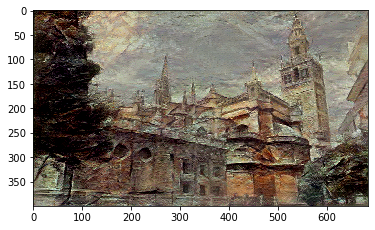

In [13]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(img)
plt.show()